# Project 14 - Detect Negative Reviews

## Project Description
Film Junky Union, a new community for classic film is developing a system to filter and categorize movie reviews. Its main mission is to train a model to automatically detect negative reviews. IMBD's *dataset* of film reviews will be used with polarity labeling to create a model that can classify positive and negative reviews. This model must have at least an F1 score of 0.85.

### Data Description

The data obtained from Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, dan Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Column description:
- `review`: review text
- `pos`: target, '0' for negative dan '1' for positive
- `ds_part`: 'train'/'test' data

### Contents of the Project
- Initialization
- Data Overview
- Explorative Data Analysis
- Evaluation Prcedure
- Model Training
- Review
- Summary and Conclusion

## Initialization

In [2]:
# Common Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Machine learning
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

import locale
locale.getpreferredencoding = lambda: "UTF-8"

import torch

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# high quality graphic
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [5]:
#!pip install transformers

In [6]:
# progress_apply, more information at https://pypi.org/project/tqdm/# pandas-integration
tqdm.pandas()

## Data Overview

In [7]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
#information of data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
#statstical description of data
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [10]:
print(df_reviews['original_title'].nunique())
print(df_reviews['primary_title'].nunique())

6562
6555


In [11]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

**Findings :**
- Dataset contain 17 columns with 47.331 rows
- The film start in 1894 and 2010 at the end of the period, while average rating start from 1.4 to 9.7
- Slight difference in both original and primary title
- Only 2 missing values for each columns in average rating and votes, we can drop it later

## Explorative Data Analysis

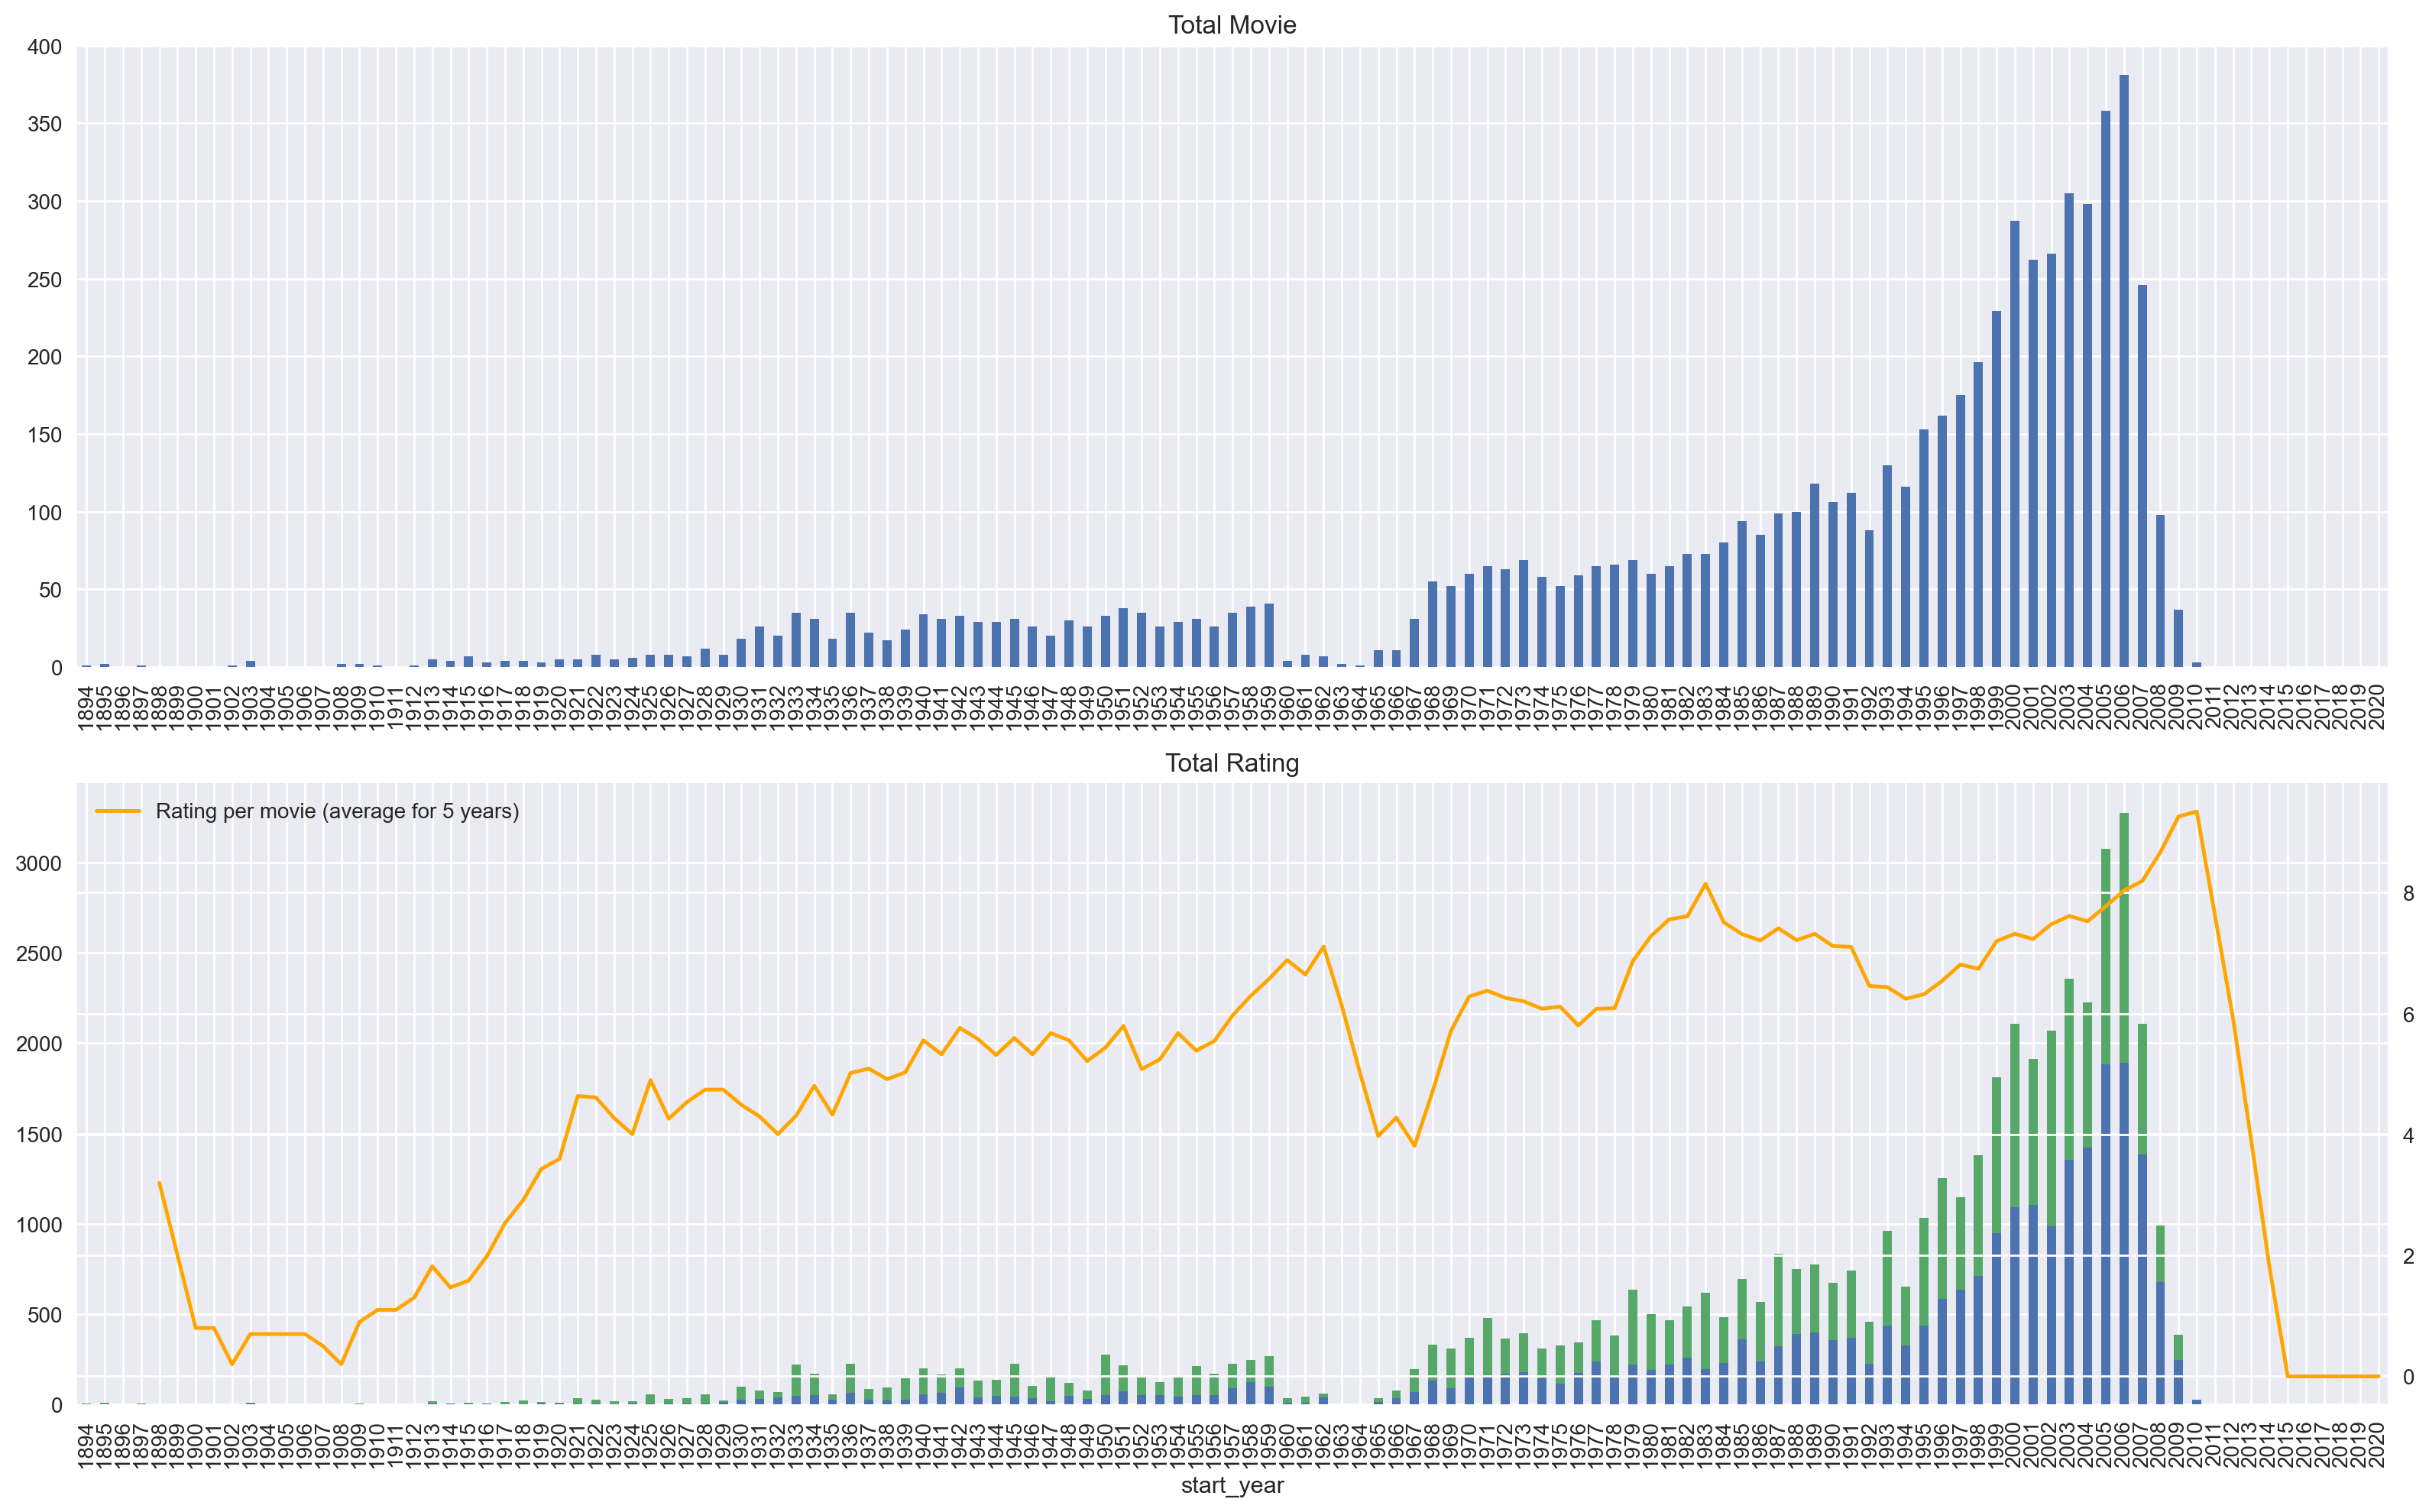

In [12]:
# Checking total film and rating for years

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Total Movie')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Rating per movie (average for 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Total Rating') 

fig.tight_layout()

**Findings :**
- Total of movies are incredibly increasing with fluctuation from 1864 to 2010
- At the beginning of the period, the reviews decrease and continue rising to 1960. For about 8 years the reviews decrease and graduallly increase at the end of the period

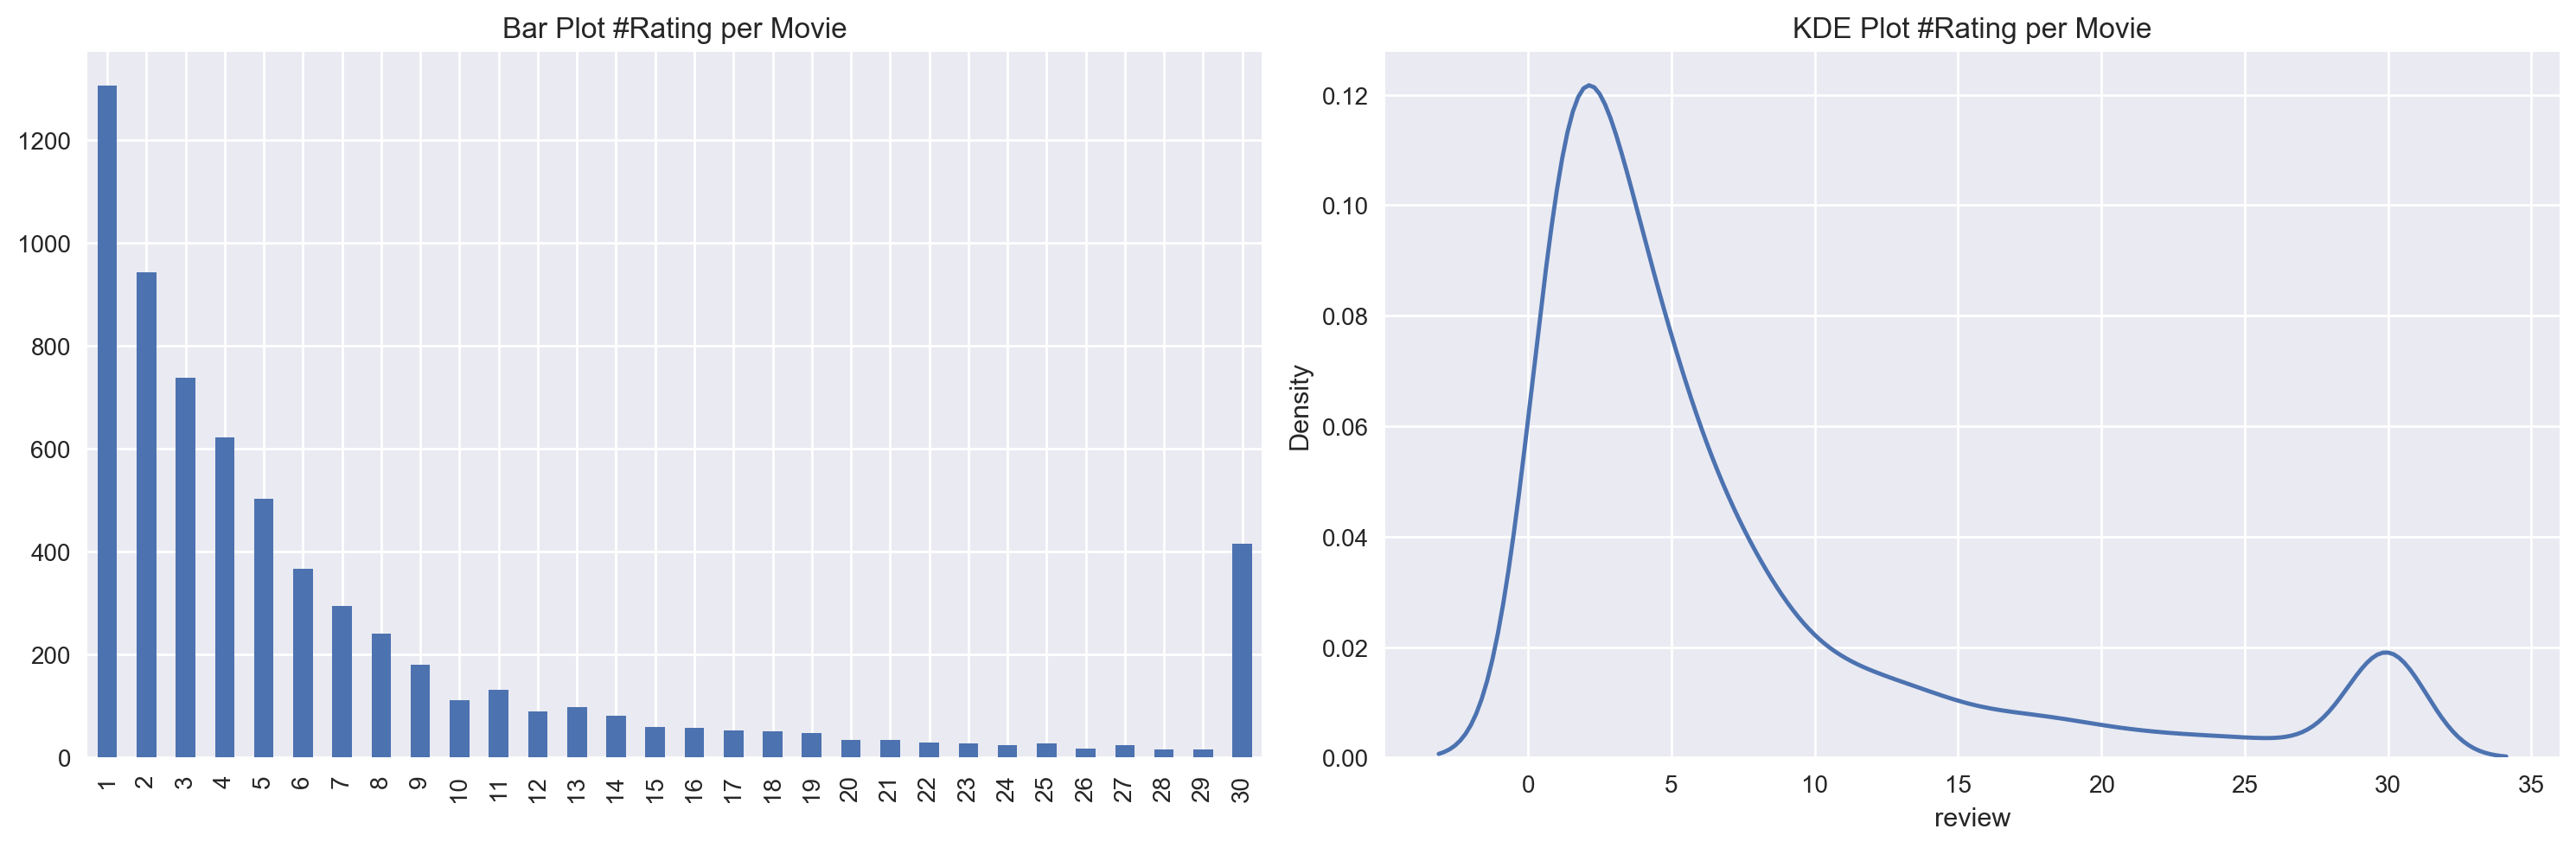

In [13]:
# Check distribution of rating per film with proper calculation and KDE (knowing different of the calculation)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot #Rating per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot #Rating per Movie') 

fig.tight_layout()

**Findings :**
- The higher the number of reviews, the lower the number of films, except for 30 reviews happen in just over 400 movies

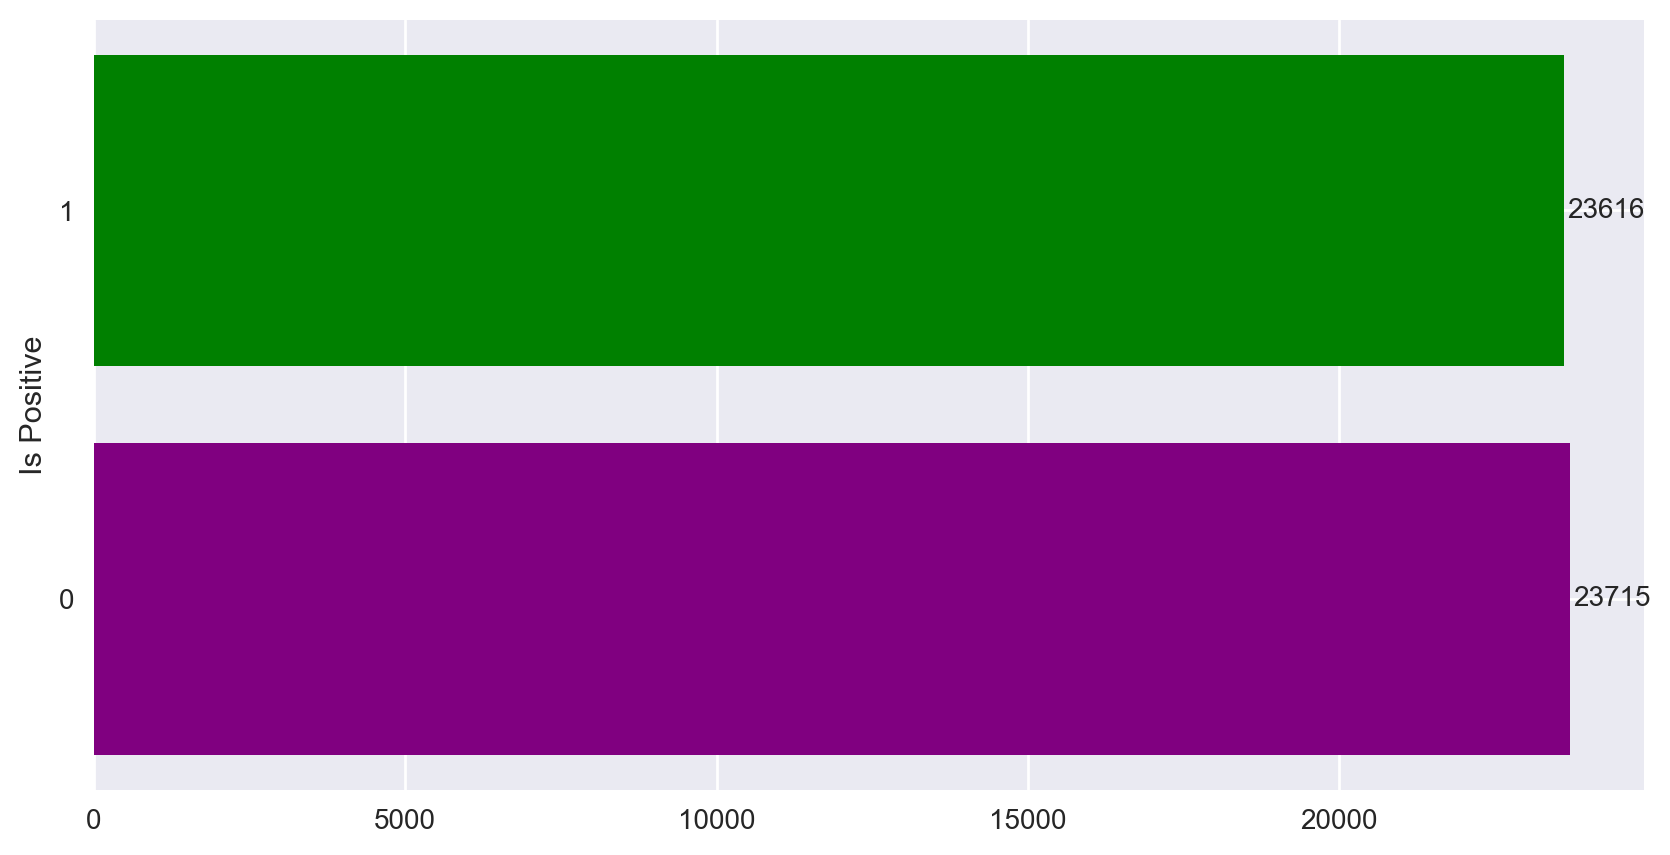

In [14]:
#check for positive and negative reviews

plt.figure(figsize=(10, 5))
pos_counts = df_reviews['pos'].value_counts()
plt.barh(pos_counts.index, pos_counts.values, color=['purple', 'green'])
plt.yticks([0, 1])
plt.ylabel('Is Positive')

for i, count in enumerate(pos_counts.values):
    plt.annotate(f'{count}', (count + 50, i), va='center')
    
plt.show()

**Findings :**
- There is no big difference between negative and positive reviews

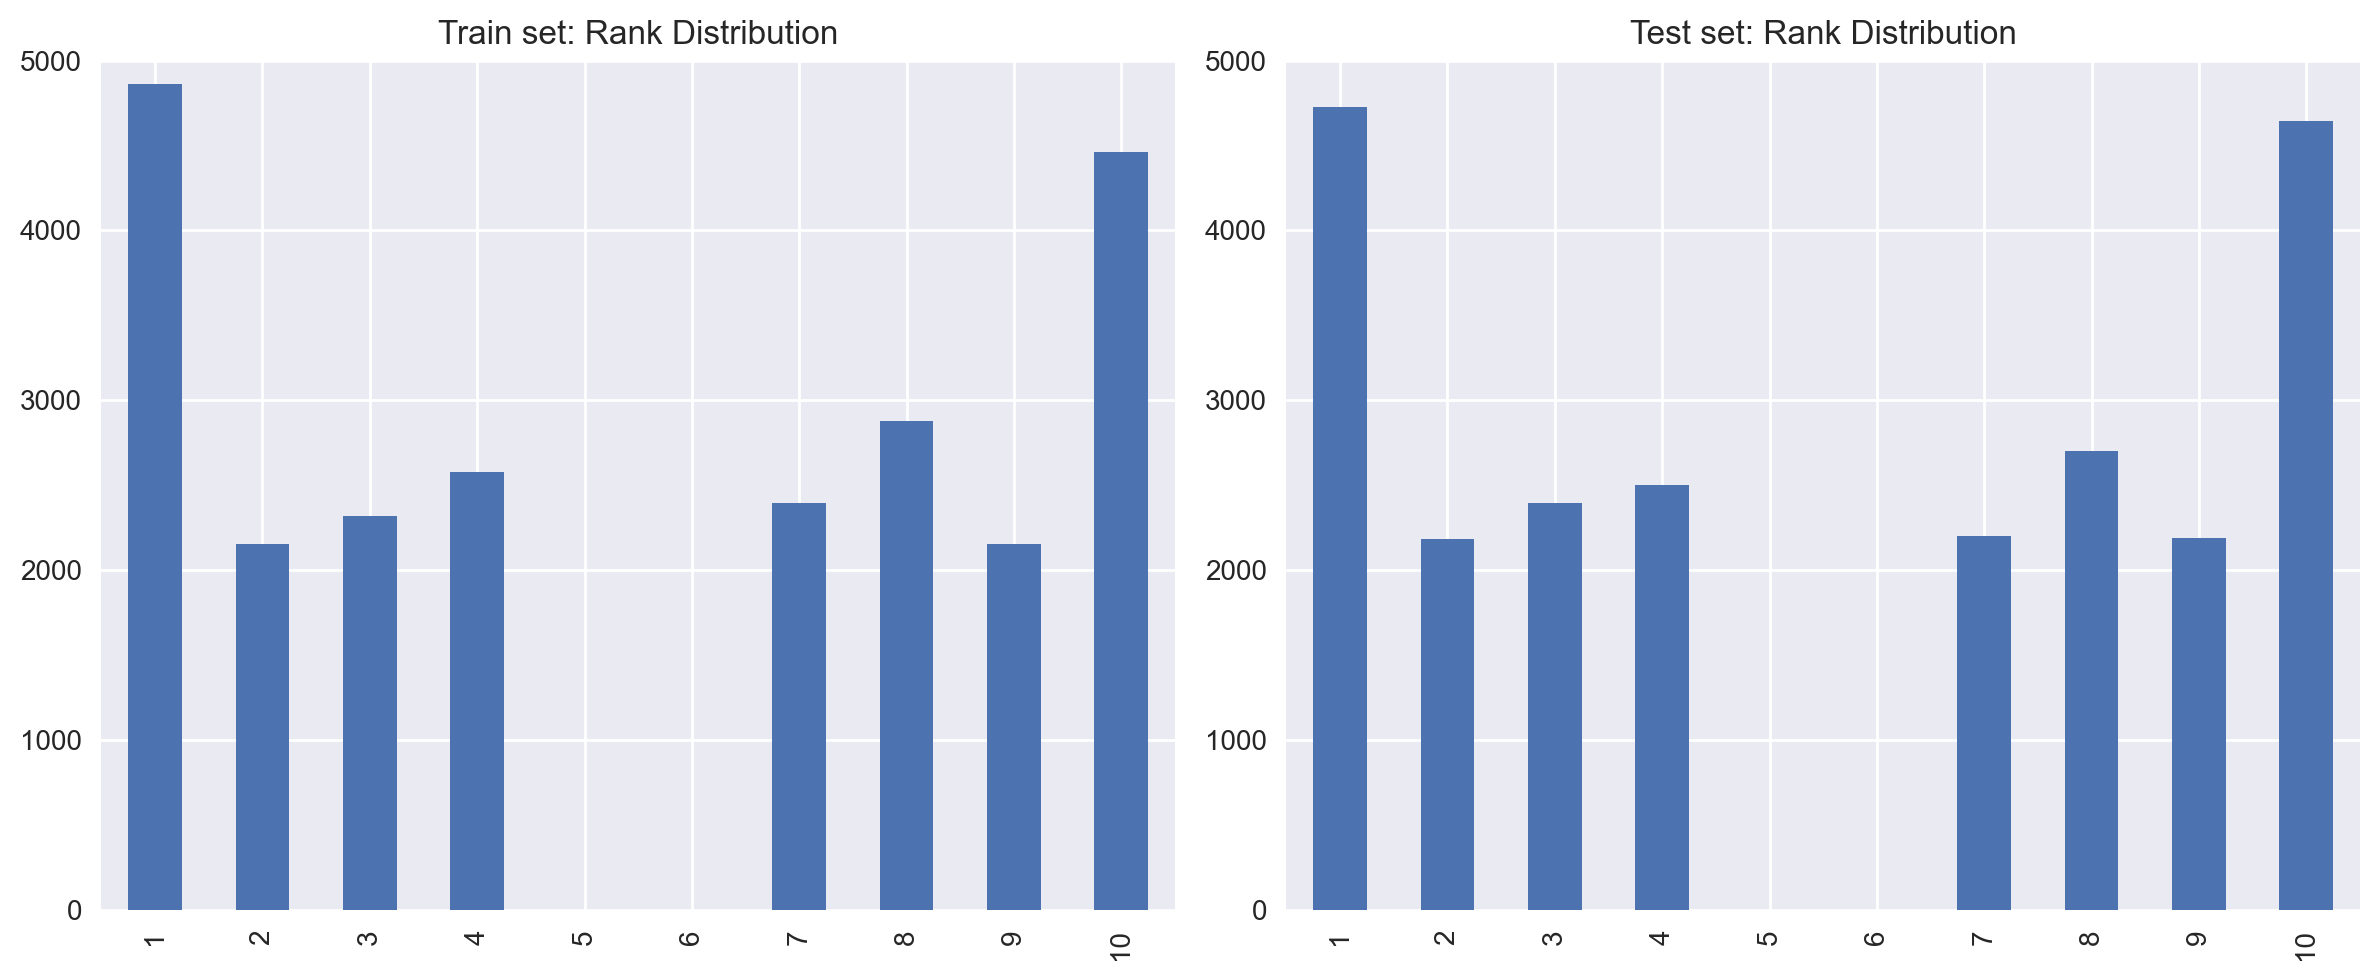

In [15]:
# Check for rating distribution

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: Rank Distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: Rank Distribution')

fig.tight_layout()

**Findings :**
- Rating 1 and 10 are the highest number among all, 5 and 6 ratings are the lowest even reached nothing, while the others are almost the same ranging between 2000 to just under 3000

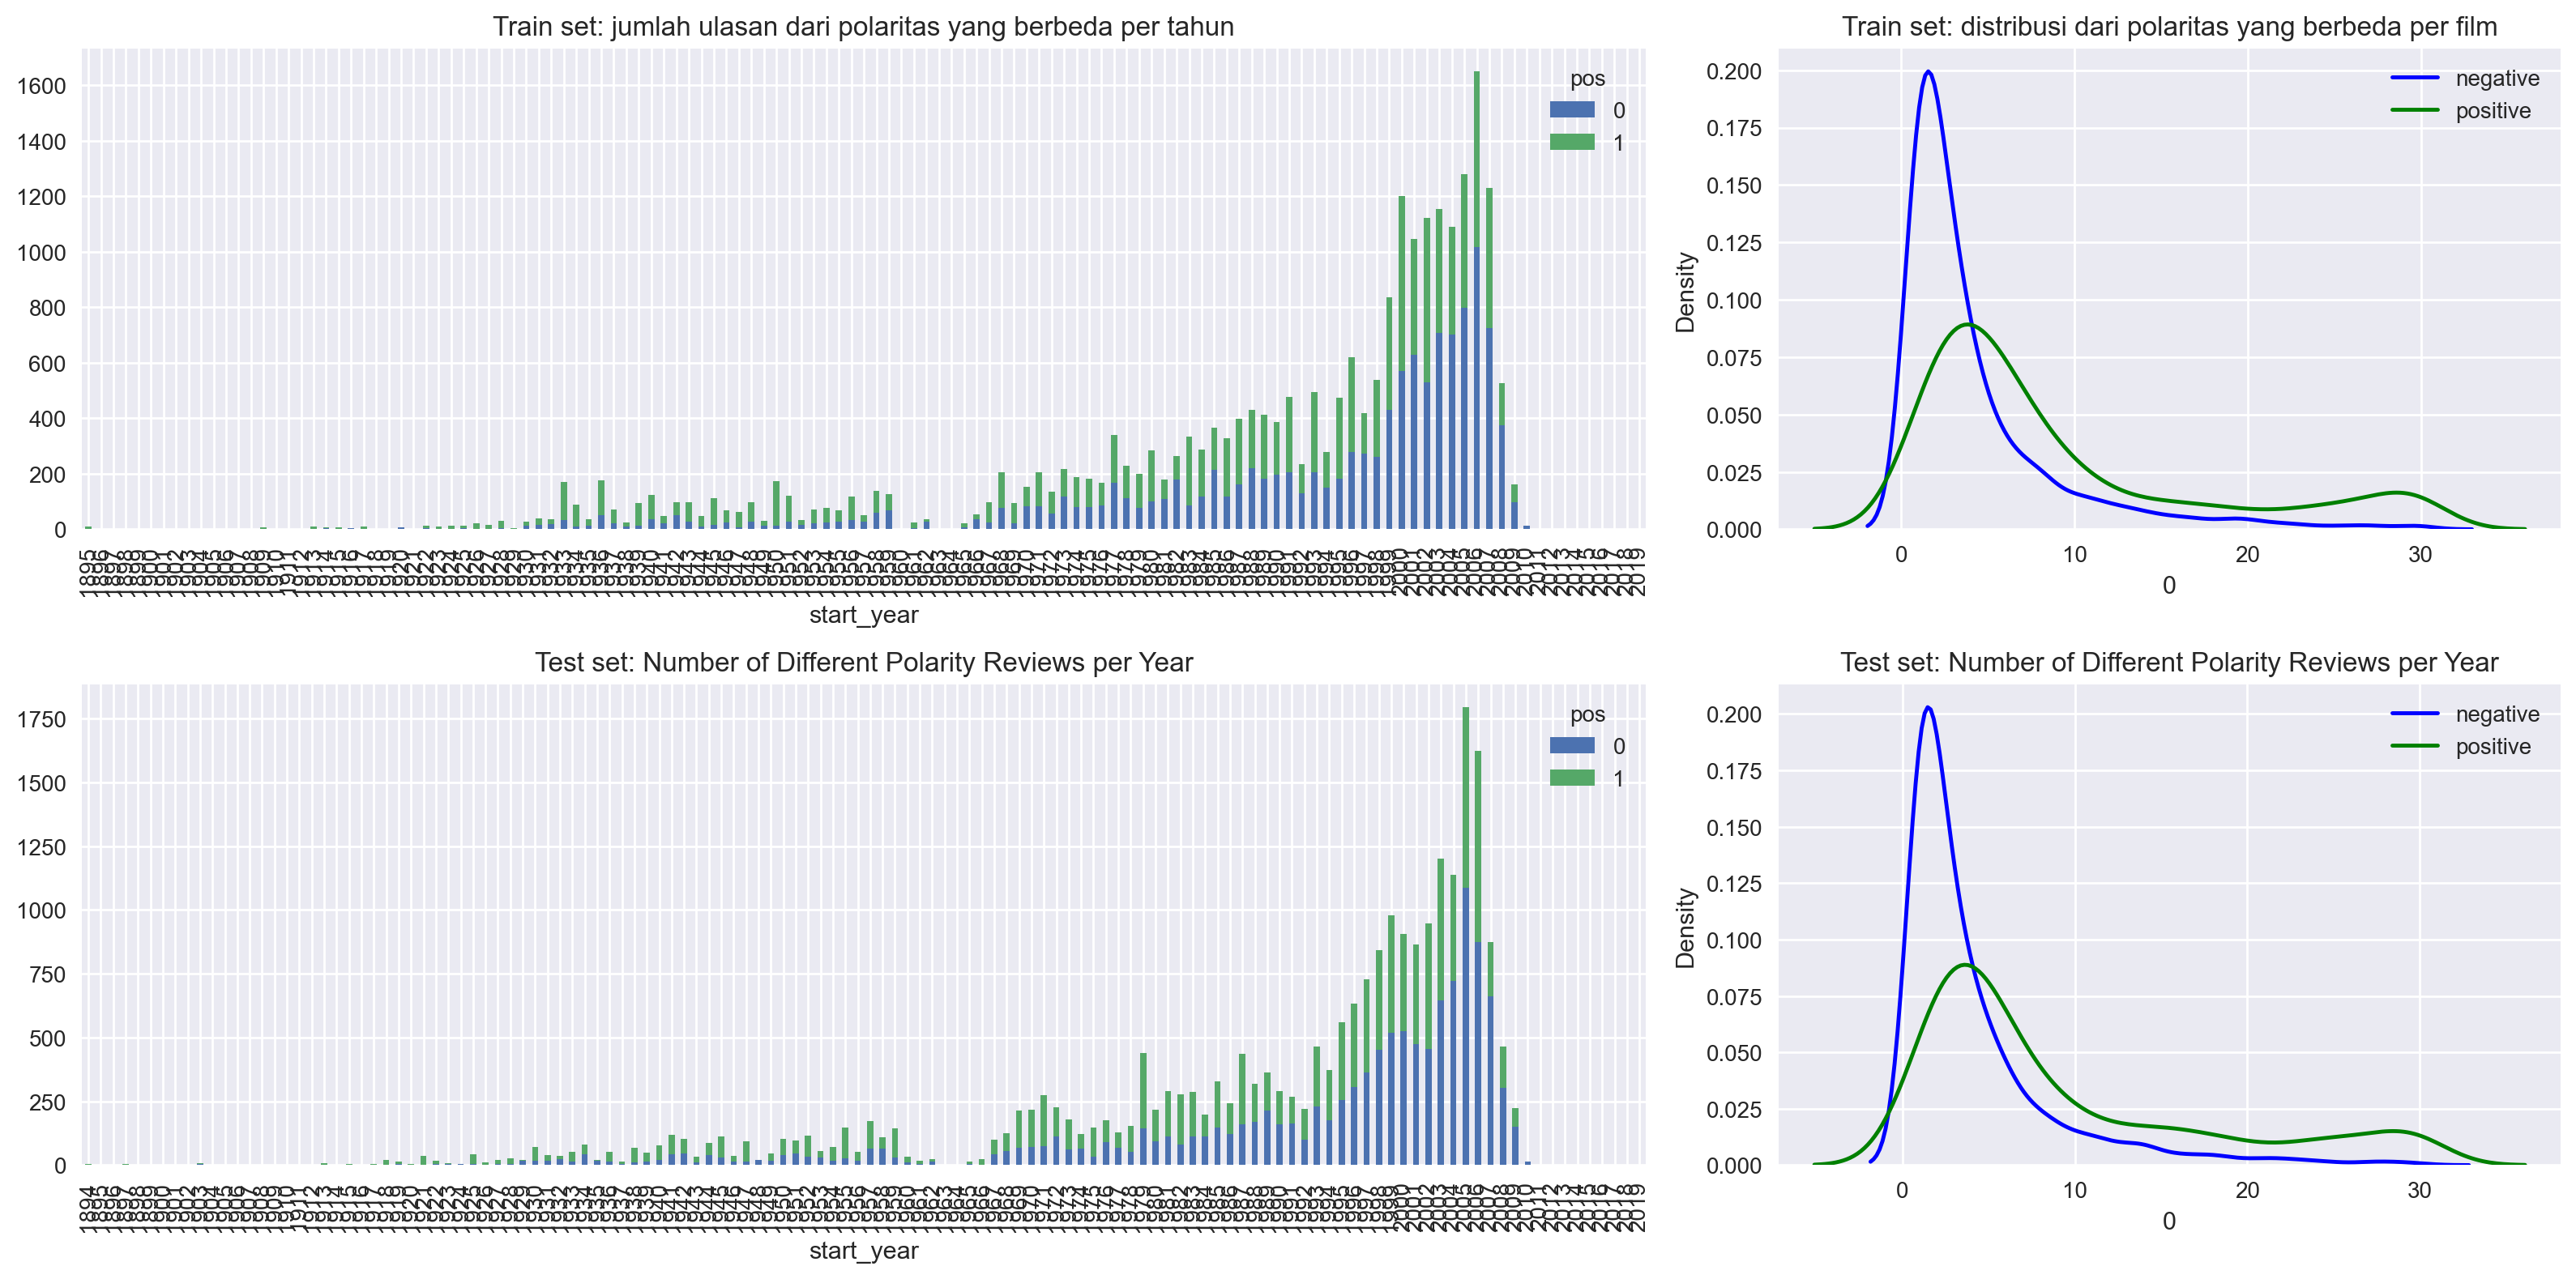

In [16]:
# Checking distribution of positive and negative reviews for years in train and test data

fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: Number of Different Polarity Reviews per Year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: Number of Different Polarity Reviews per Year')

fig.tight_layout()

**Findings :**
- Even though the different between positive and negative reviews have small number, but on the distribution seem huge different

## Evaluation Procedure

In [17]:
# Evaluation for all models

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalization

In [18]:
# Discharged lowercase, numbers, punctuation, etc

df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

C:\Users\Mahendra Alfath\AppData\Local\Temp\ipykernel_19152\349426023.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')


In [19]:
df_reviews[['review_norm']].head()

,review_norm
0,the pakage implies that warren beatty and gold...
1,how the hell did they get this made presenti...
2,there is no real story the film seems more lik...
3,um a serious film about troubled teens in...
4,i m totally agree with garryjohal from singapo...


### Train-Test Data

In [20]:
# Separate train-test data by ds_part

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


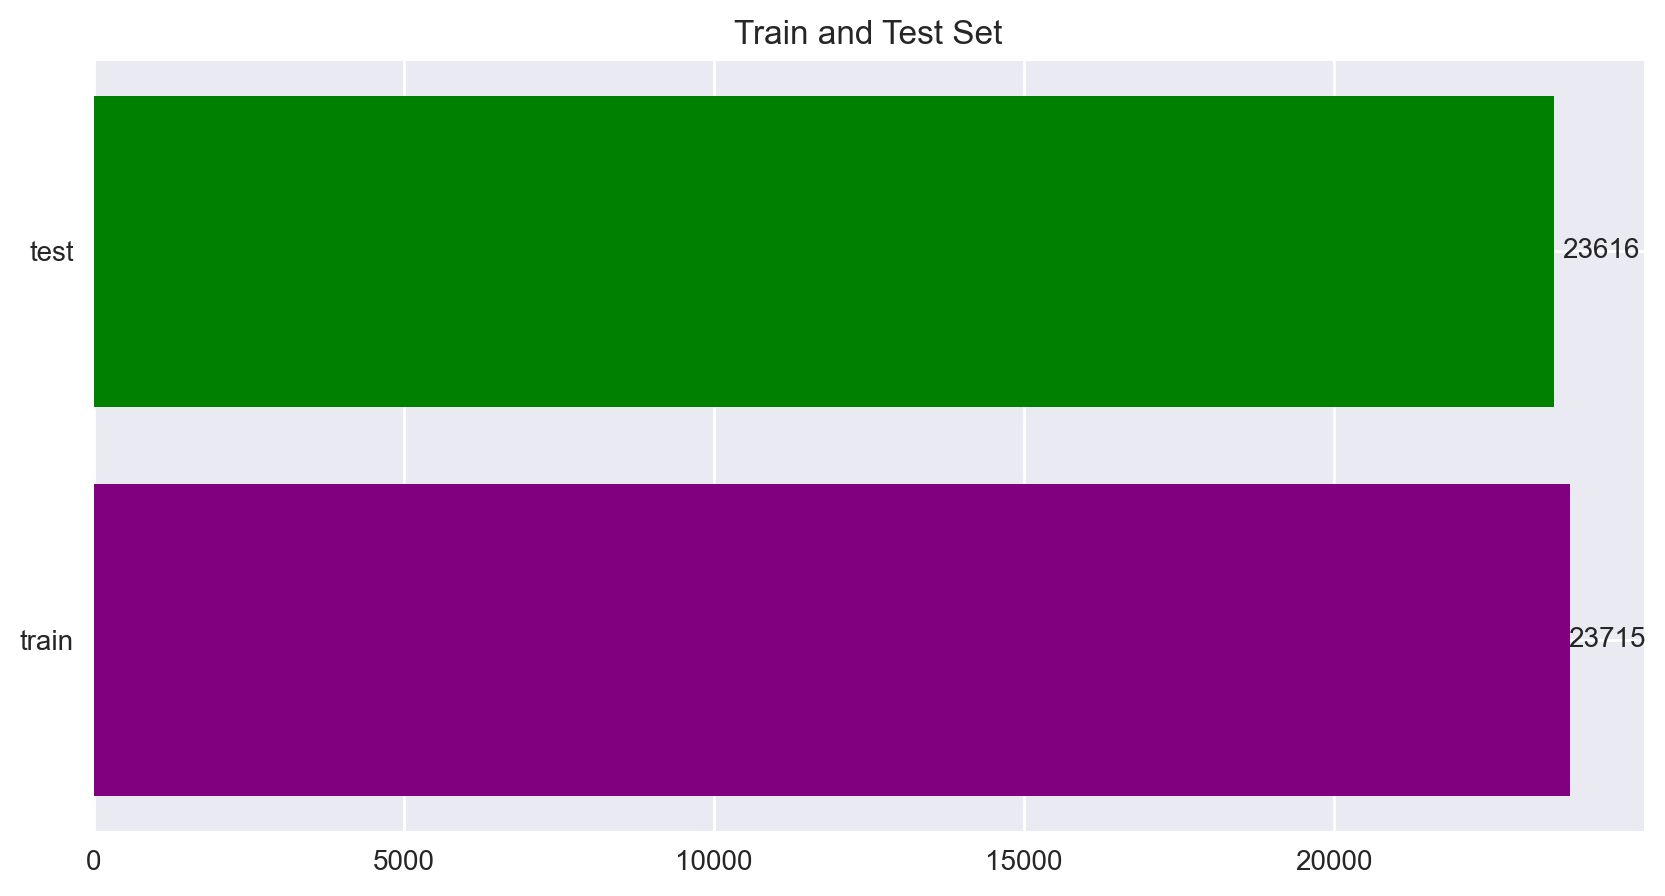

In [21]:
plt.figure(figsize=(10, 5))
train_test = df_reviews['ds_part'].value_counts()
plt.barh(train_test.index, train_test.values, color=['purple', 'green'])
plt.yticks([0, 1])
plt.title('Train and Test Set')

for i, count in enumerate(pos_counts.values):
    plt.annotate(f'{count}', (count + 50, i), va='center')
    
plt.show()

## Model Training

### Model 0 - Konstan

In [22]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    NaN   NaN
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


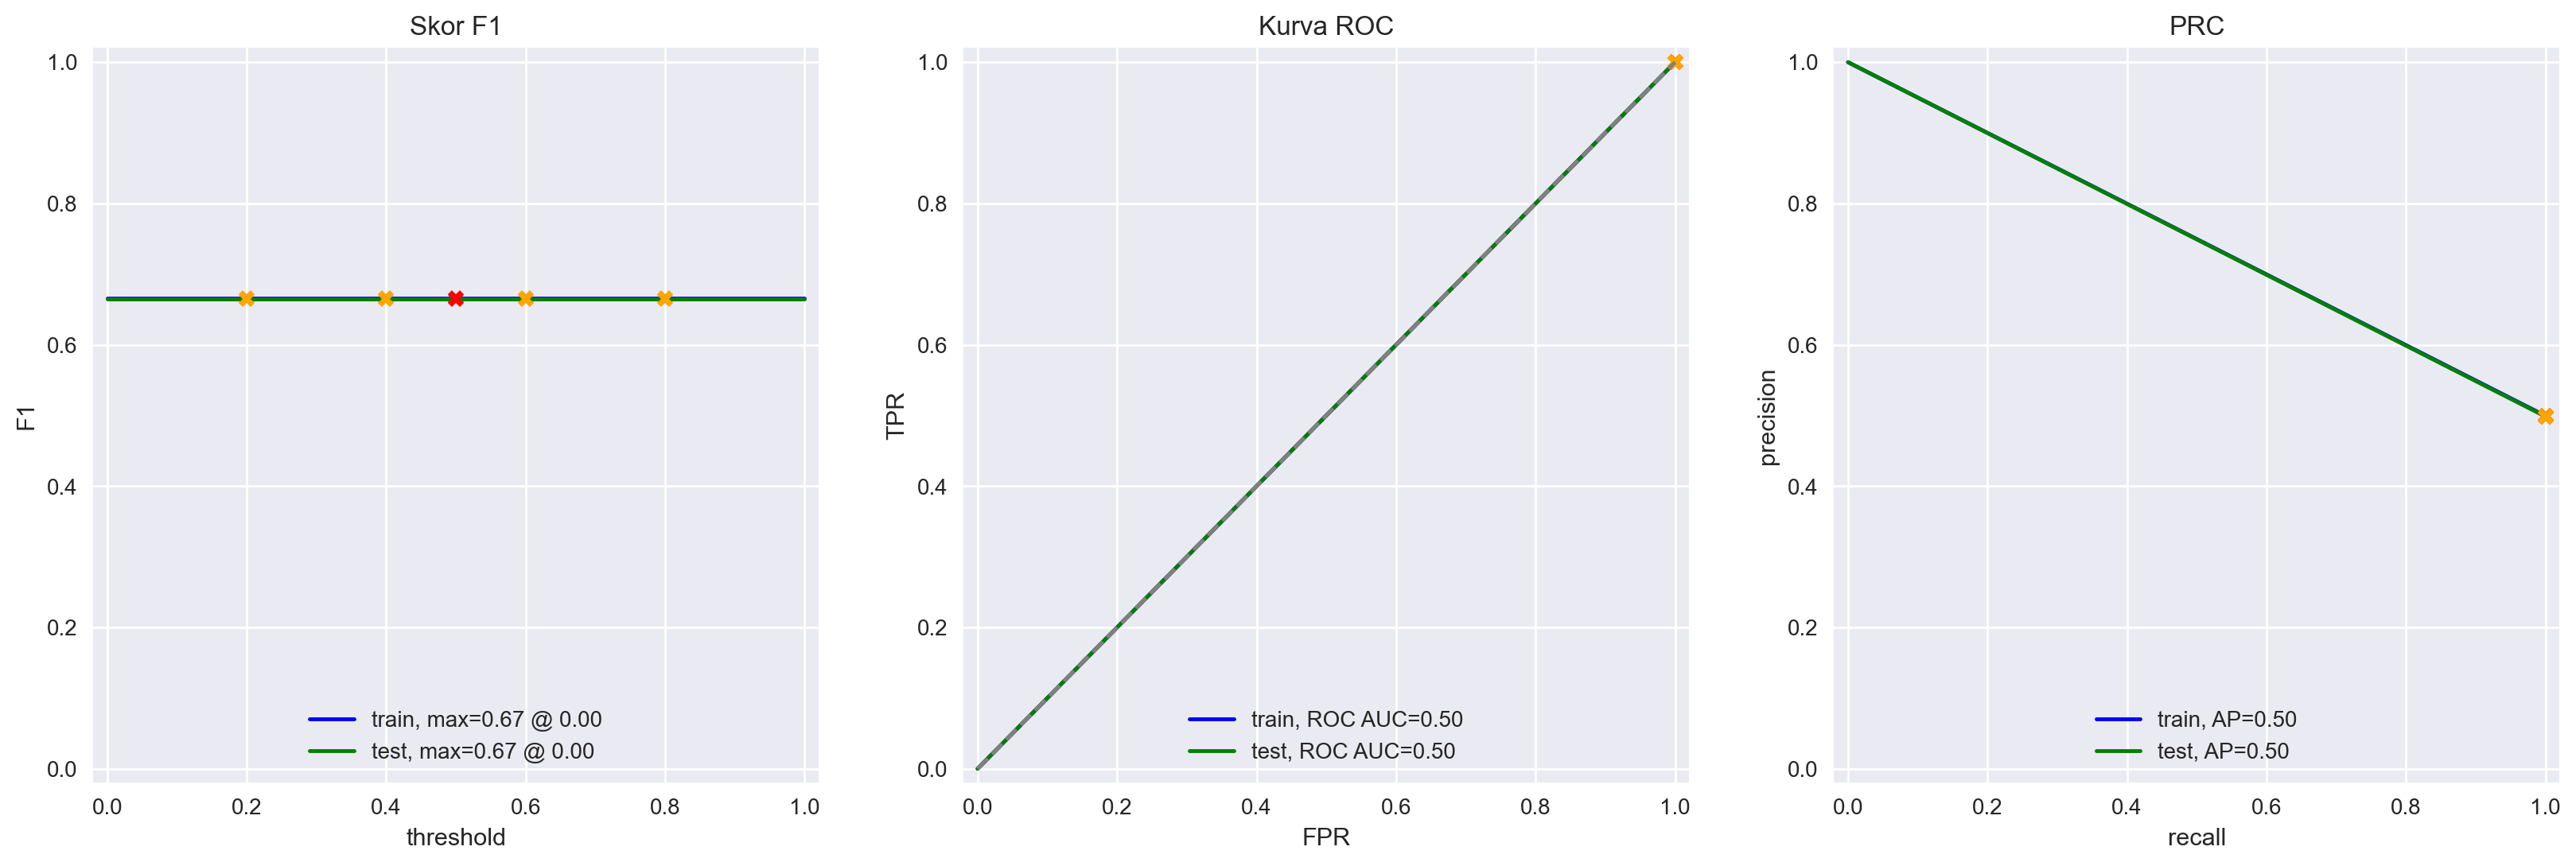

In [23]:
# Dummy classifier model

dummy_clf = DummyClassifier(strategy='constant', constant=1).fit(X=df_reviews_train, y=train_target)

evaluate_model(dummy_clf, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Findings :**
- F1 score is far from the specified threshold value in dummy classifier model 

### Model 1.1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Mahendra
[nltk_data]     Alfath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# stopwords identification

tfidf_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

In [26]:
# fit_transform for train data
train_features = tfidf_1.fit_transform(df_reviews_train['review_norm'])
print(train_features.shape)

## transform for test data
test_features = tfidf_1.transform(df_reviews_test['review_norm'])
print(train_features.shape)

(23796, 71531)
(23796, 71531)


In [27]:
# LR model training
lr_1 = LogisticRegression()
lr_1.fit(train_features, train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


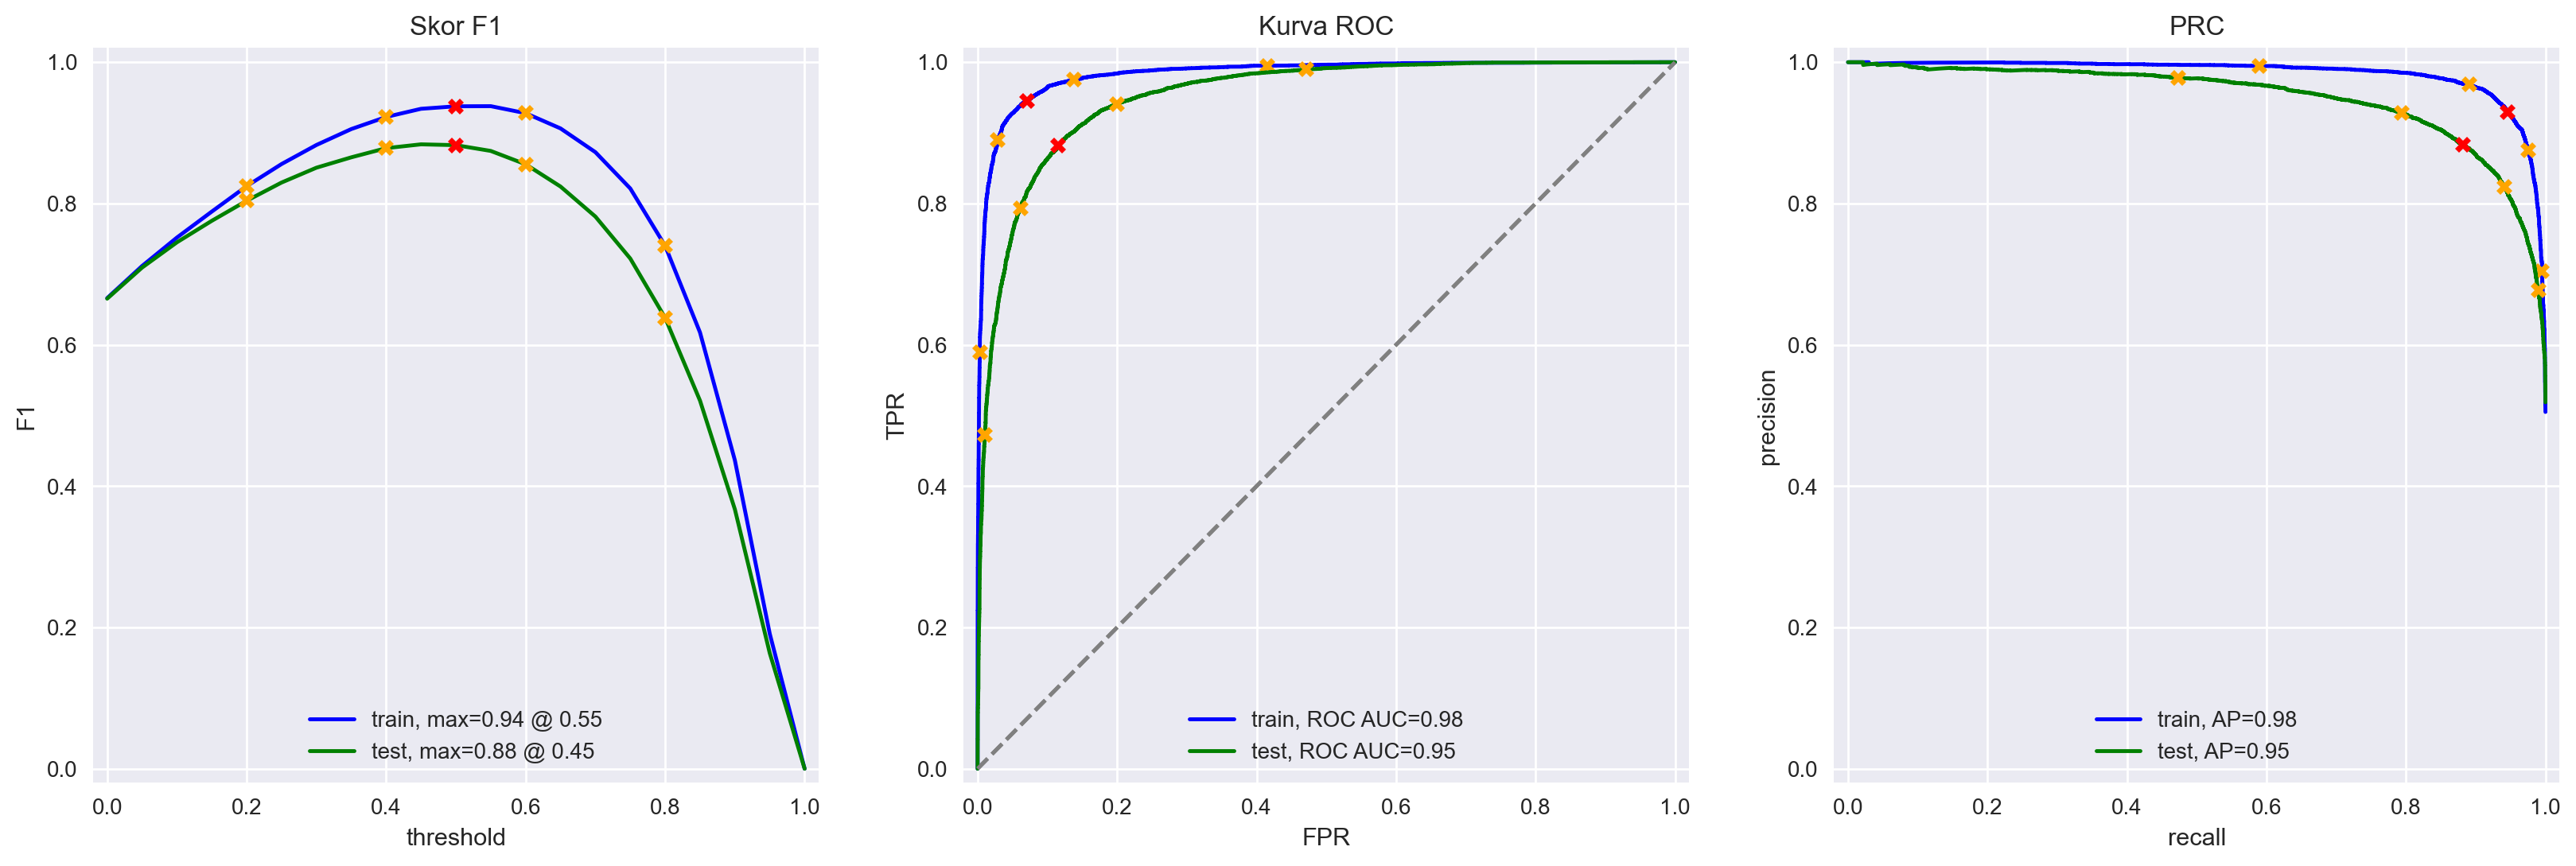

In [28]:
evaluate_model(lr_1, train_features, train_target, test_features, test_target)

**Findings :**
- LR with NLTK, TF-IDF generates better F1 score than dummy classifier model and passes the threshold value.

### Model 1.2 - NLTK, TF-IDF and XGBoost

In [29]:
%%time

xgboost = []

for depth_xgb in range(1,6):
    xgbo = xgb.XGBClassifier(max_depth=depth_xgb)
    xgbo.fit(train_features, train_target)
    
    pred_train_xgb = xgbo.predict(train_features)
    f1_score_xgb = f1_score(train_target, pred_train_xgb)
    
    xgboost.append({'max_depth': depth_xgb, 'train_f1_score': f1_score_xgb})

df = pd.DataFrame(xgboost)
df

Wall time: 48.2 s


,max_depth,train_f1_score
0,1,0.822382
1,2,0.855900
2,3,0.879050
3,4,0.904693
4,5,0.924937


In [30]:
# check model for test data in XGBoost

xgbo_test = xgb.XGBClassifier(max_depth=5)
xgbo_test.fit(train_features, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

          train  test
Accuracy    NaN   NaN
F1         0.92  0.85
APS        0.98  0.93
ROC AUC    0.98  0.93


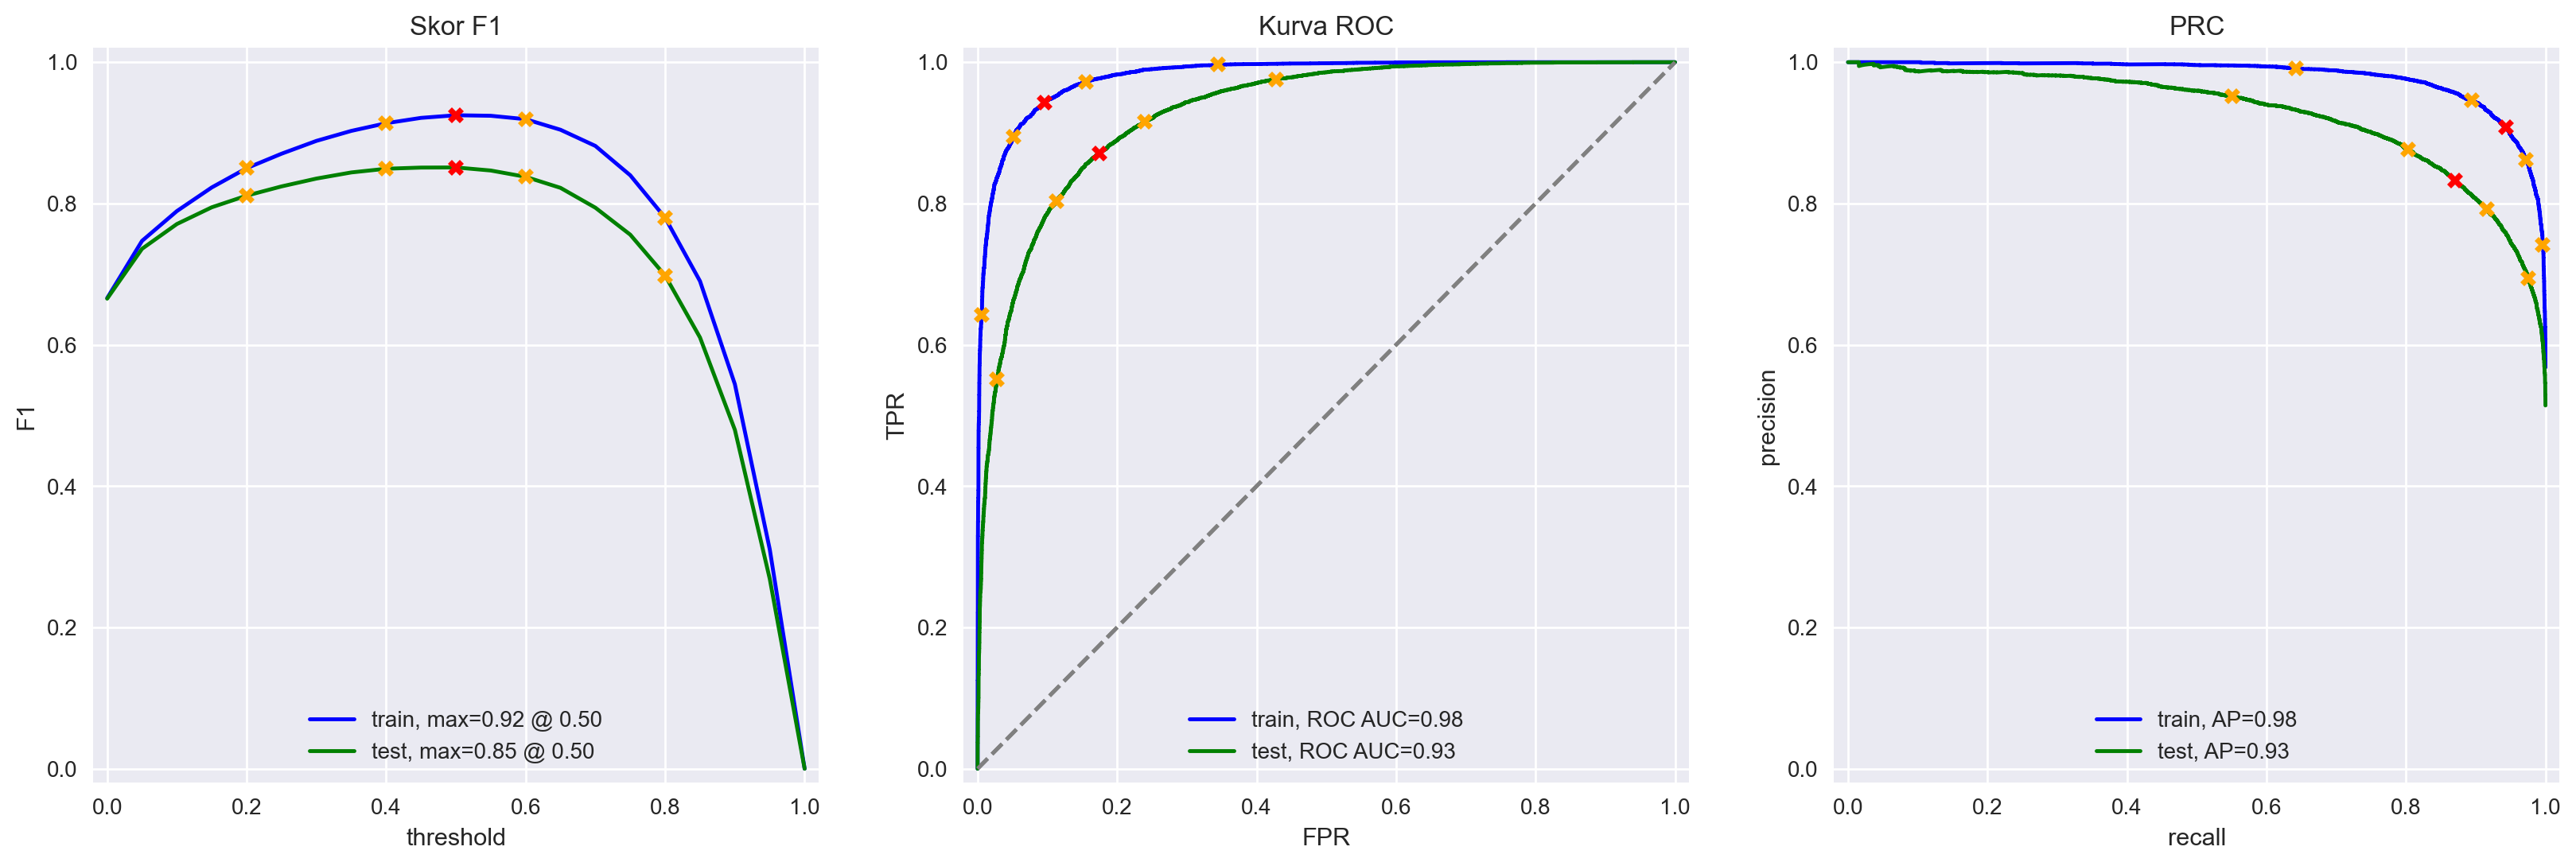

In [31]:
evaluate_model(xgbo_test, train_features, train_target, test_features, test_target)

**Findings :**
- F1 score of XGB with NLTK, TF-IDF is not better than vectorization results with Logistic Regression, but this model is less prone to overfitting that makes this model better.

### Model 2.1 - spaCy, TF-IDF and LR

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
%%time

df_reviews_train['review_tokens_2'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_2(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

Wall time: 5min 37s


In [35]:
%%time

df_reviews_test['review_tokens_2'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_2(x))

  0%|          | 0/23535 [00:00<?, ?it/s]

Wall time: 5min 18s


In [36]:
# tf-idf function

tfidf_2 = TfidfVectorizer()

In [37]:
# fit_transform for train data
train_features_2 = tfidf_2.fit_transform(df_reviews_train['review_tokens_2'])
print(train_features_2.shape)

## transform for test data
test_features_2 = tfidf_2.transform(df_reviews_test['review_tokens_2'])
print(train_features_2.shape)

(23796, 58951)
(23796, 58951)


In [38]:
# LR model training
lr_2 = LogisticRegression()
lr_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


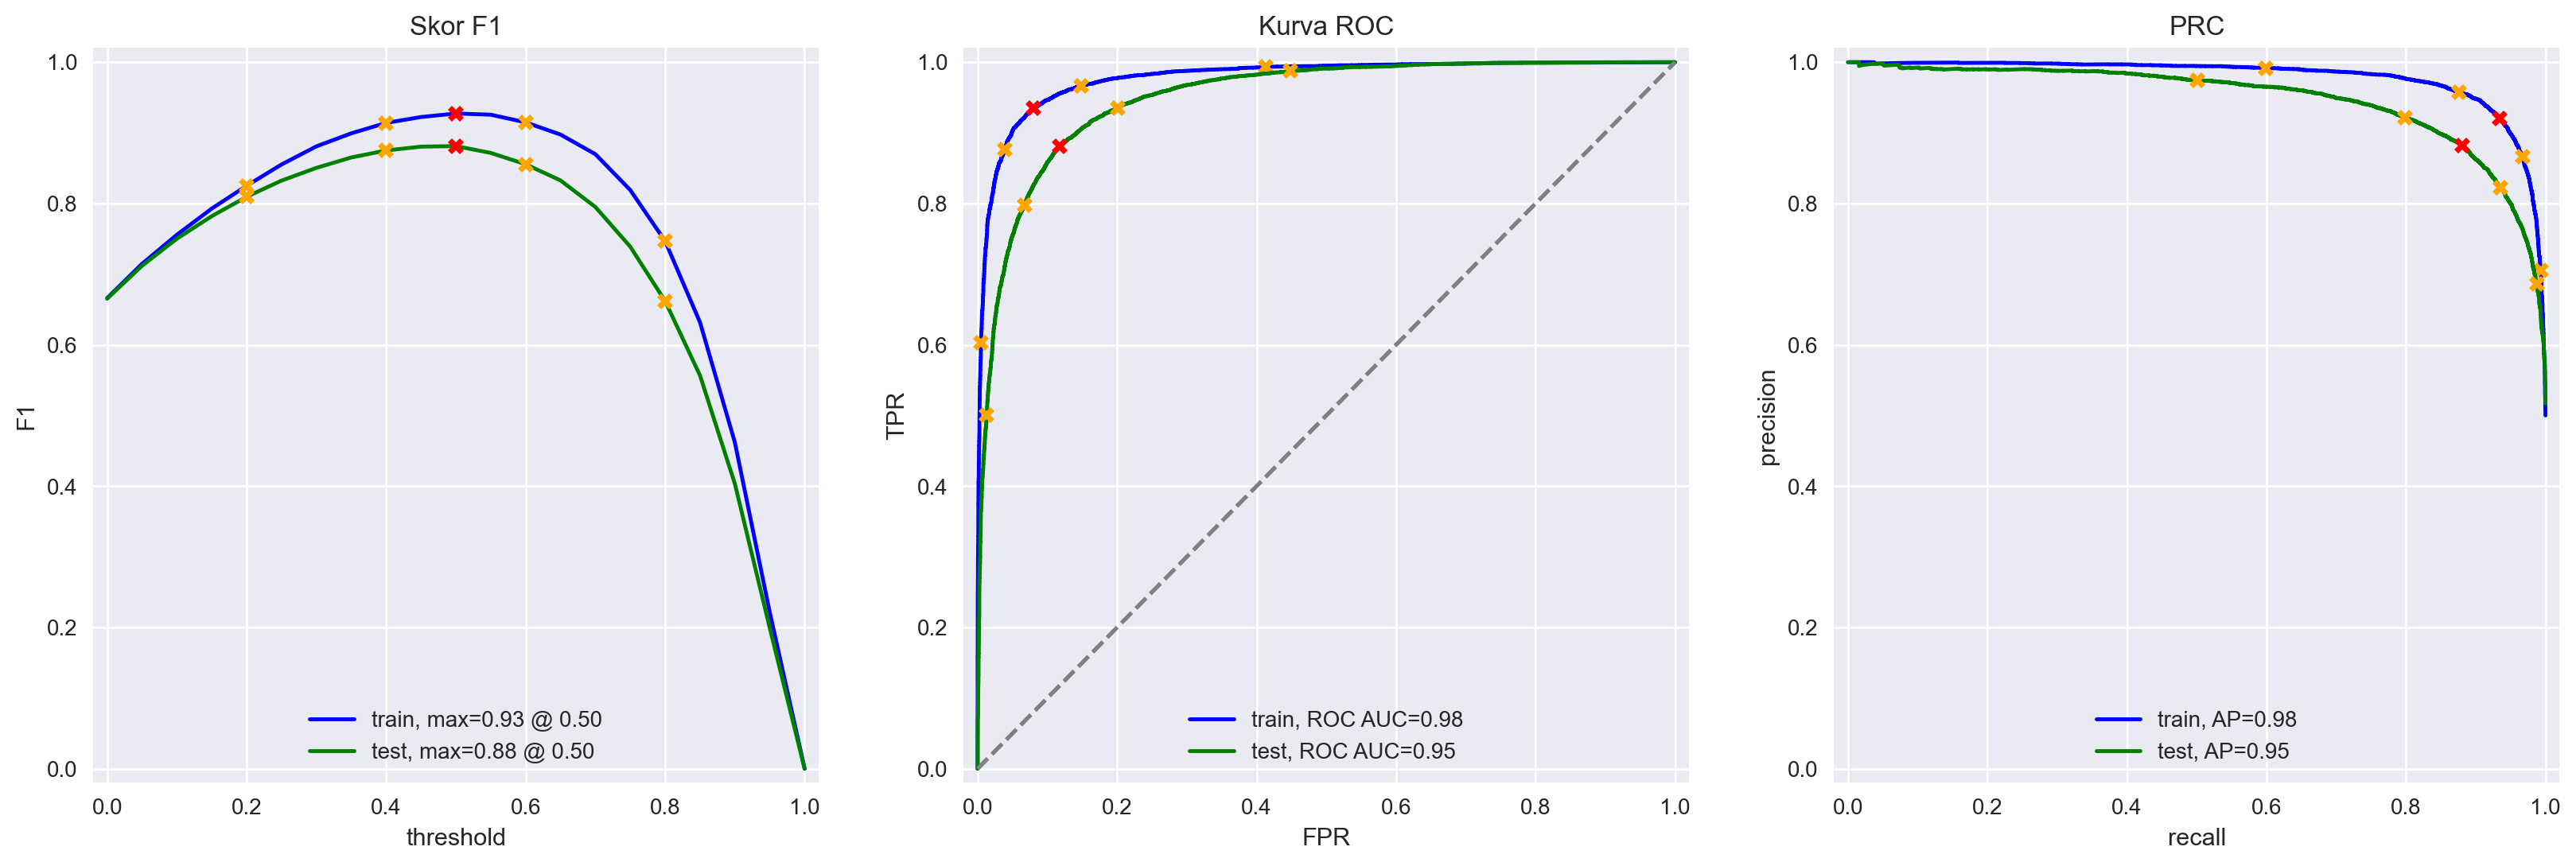

In [39]:
evaluate_model(lr_2, train_features_2, train_target, test_features_2, test_target)

**Findings :**
- LR with spacy generates f1 score slightly better than with NLTK vectorization

### Model 2.3 - spaCy, TF-IDF and LGBMClassifier

In [40]:
%%time

lightgbm = []

for depth_lgb in range(1, 6):
    for leave in range(100, 501, 100):
        lgb = lgbm.LGBMClassifier(num_leaves=leave, max_depth=depth_lgb)
        lgb.fit(train_features_2, train_target)
        
        pred_train_lgb = lgb.predict(train_features_2)
        f1_score_lgb = f1_score(train_target, pred_train_lgb)
        
        lightgbm.append({'max_depth': depth_lgb, 'num_leaves': leave, 'train_f1_score': f1_score_lgb})

df = pd.DataFrame(lightgbm)
df

Wall time: 1min 47s


,max_depth,num_leaves,train_f1_score
0,1,100,0.783365
1,1,200,0.783365
2,1,300,0.783365
3,1,400,0.783365
4,1,500,0.783365
5,2,100,0.813288
6,2,200,0.813288
7,2,300,0.813288
8,2,400,0.813288
9,2,500,0.813288


In [41]:
# Check model for test data in LightGBM

lgb_test = lgbm.LGBMClassifier(num_leaves=100, max_depth=5)
lgb_test.fit(train_features_2, train_target)

LGBMClassifier(max_depth=5, num_leaves=100)

          train  test
Accuracy    NaN   NaN
F1         0.88  0.83
APS        0.95  0.91
ROC AUC    0.95  0.91


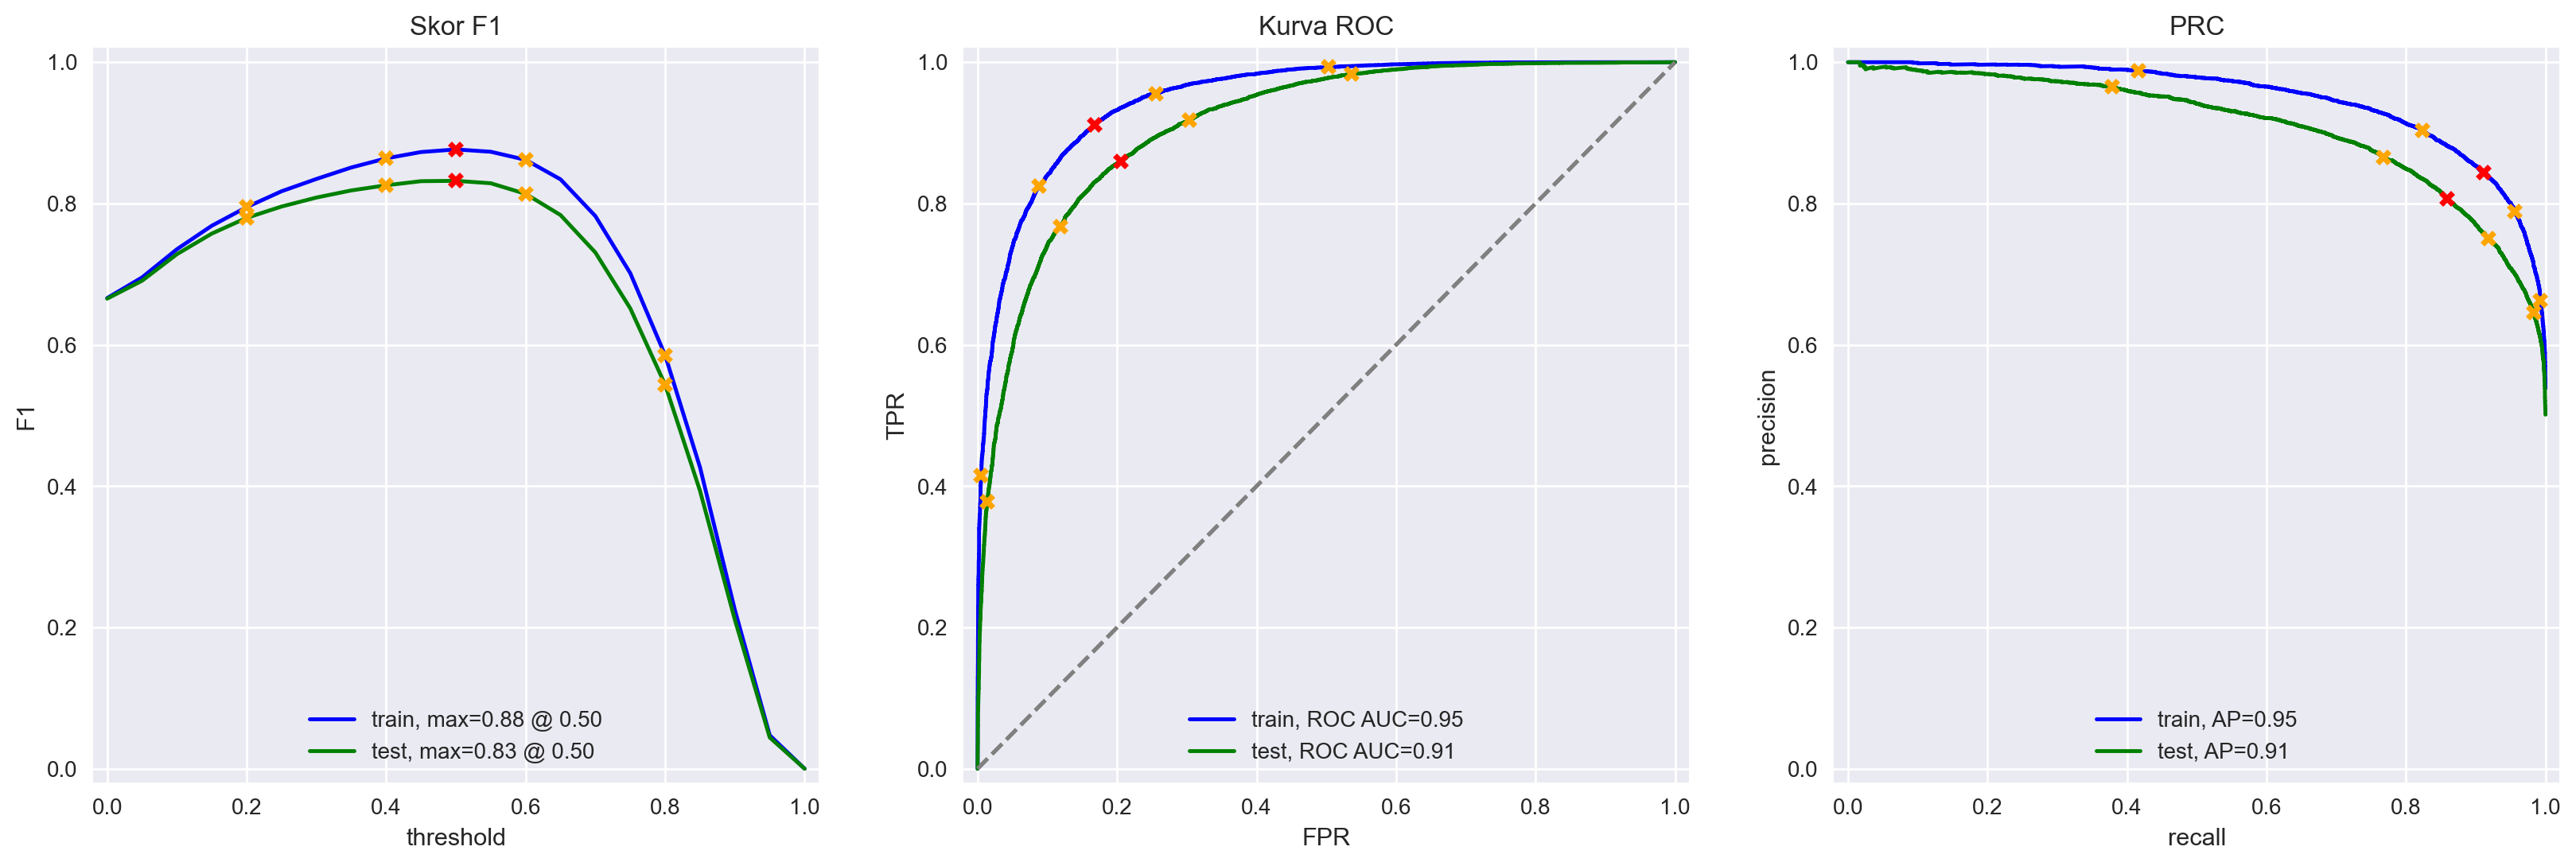

In [42]:
evaluate_model(lgb_test, train_features_2, train_target, test_features_2, test_target)

**Findings :**
- LGBM with Spacy, TF-IDF generates F1 score that is not better than LR model with Spacy, TF-IDF.

###  Model 3.1 - BERT and LR

In [43]:
import torch
import transformers
import math
from torch.utils.data import DataLoader, TensorDataset

In [44]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
import math

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
    
    # dapatkan embedding dalam batch 

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device) 
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Convert text into a token ID and BERT tokenizer will insert the token ID

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    # Tokenize and prepare input tensors
    ids_list = []
    attention_mask_list = []
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    input_ids = torch.LongTensor(ids_list)
    attention_mask = torch.LongTensor(attention_mask_list)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    if not disable_progress_bar:
        print(f'Using {device} device.')
    
    # Prepare DataLoader for batching
    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    embeddings = []
    with torch.no_grad():
        model.eval()
        for ids_batch, attention_mask_batch in tqdm(dataloader, disable=disable_progress_bar):
            ids_batch, attention_mask_batch = ids_batch.to(device), attention_mask_batch.to(device)
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
            embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())
    
    return np.concatenate(embeddings)


In [46]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [47]:
%%time

train_features_3 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
print(train_features_3.shape)

  0%|          | 0/23796 [00:00<?, ?it/s]

Gunakan cuda perangkat.


  0%|          | 0/238 [00:00<?, ?it/s]

(23796, 768)
Wall time: 3h 15min 12s


In [48]:
%%time

test_features_3 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')
print(test_features_3.shape)

  0%|          | 0/23535 [00:00<?, ?it/s]

Gunakan cuda perangkat.


  0%|          | 0/236 [00:00<?, ?it/s]

(23535, 768)
Wall time: 3h 12min 15s


In [49]:
# LR model training
lr_3 = LogisticRegression()
lr_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


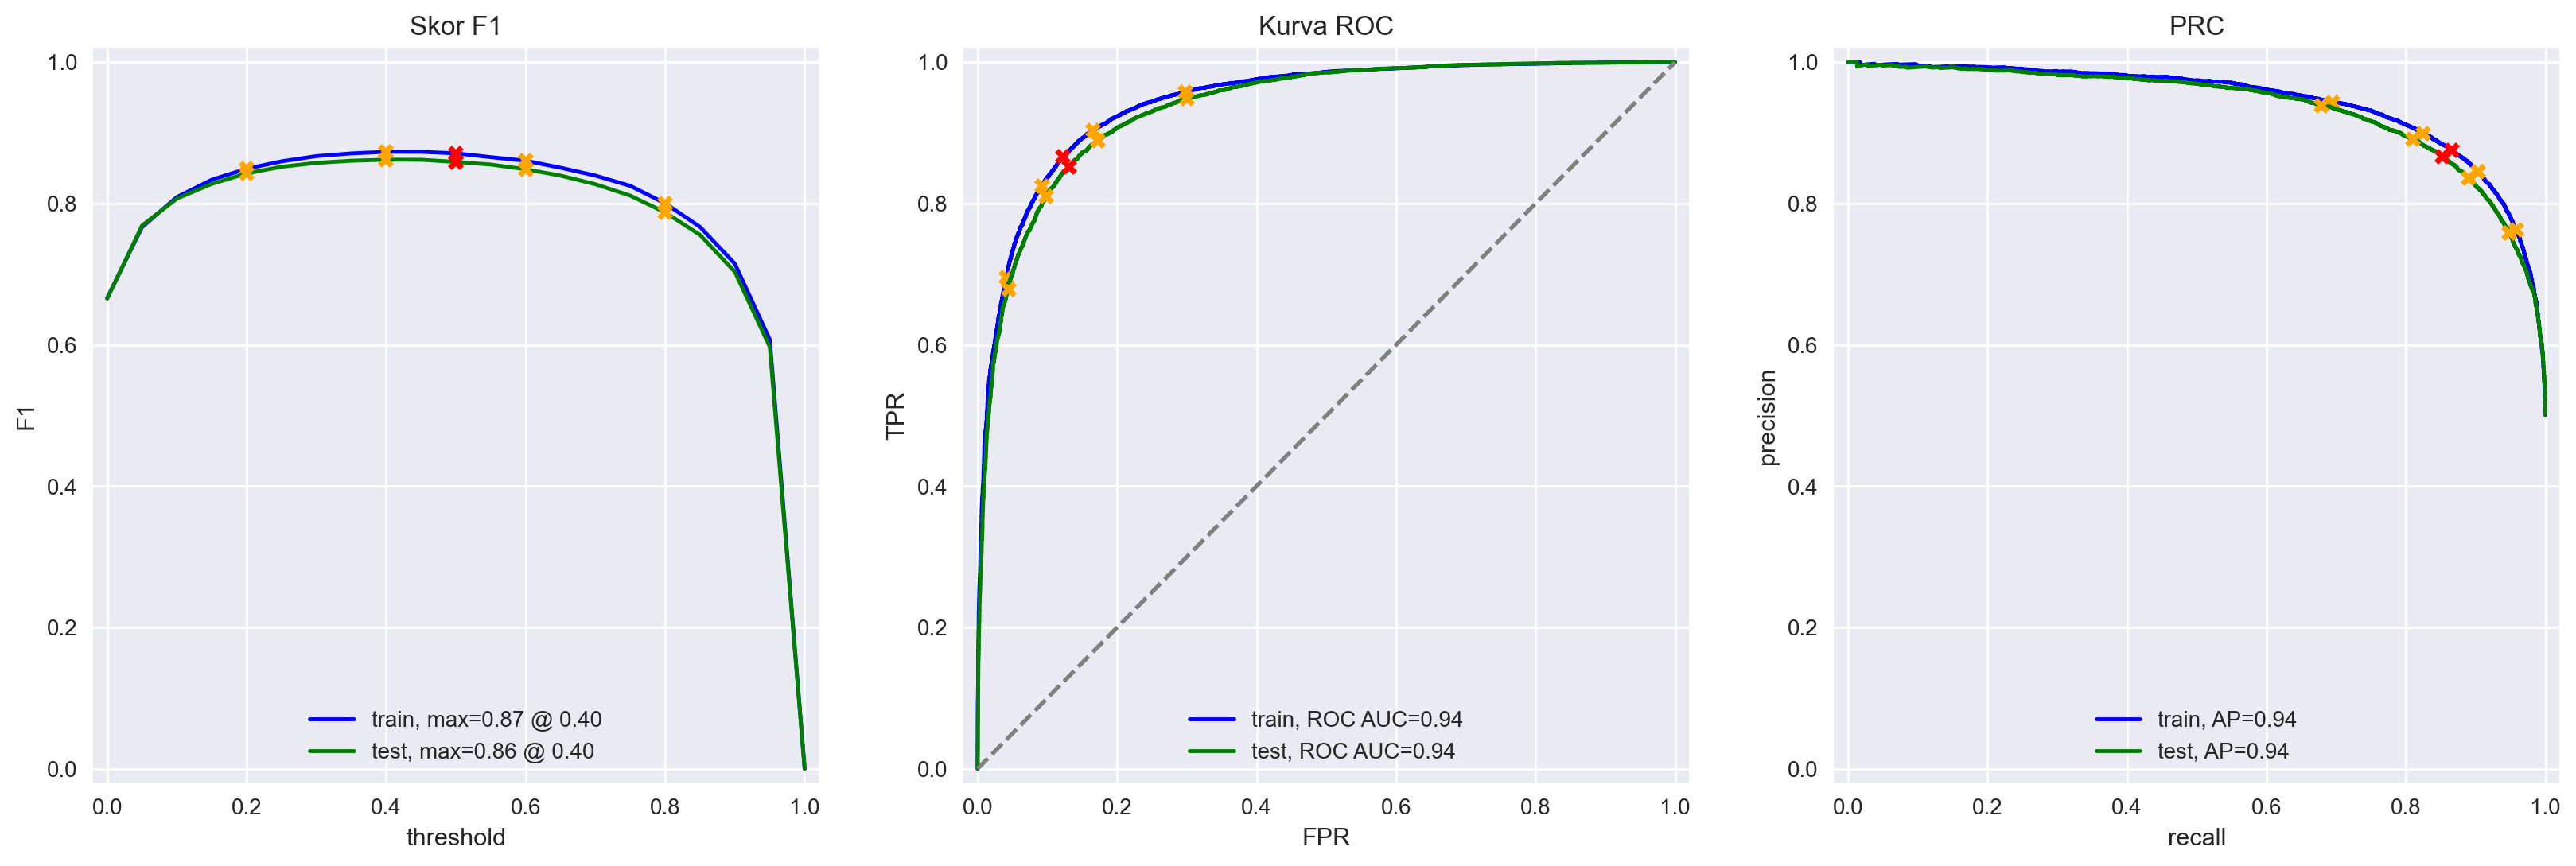

In [50]:
evaluate_model(lr_3, train_features_3, train_target, test_features_3, test_target)

**Findings :**
- F1 score that generated by LR model with Bert gives is not significantly different from previous models, but this has better performance from overfitting.

### Model 3.2 - BERT and CatBoost

In [51]:
%%time

catboost = []

for depth_cbo in range(1,6):
    for iterations in range(50, 101, 10):
        cbo = cb.CatBoostClassifier(depth=depth_cbo,  
                                   iterations=iterations, 
                                   random_seed=12345)
        cbo.fit(train_features_3, train_target, verbose=False)
    
        pred_train_cb = cbo.predict(train_features_3)
        f1_score_cb = f1_score(train_target, pred_train_cb)
    
        catboost.append({'max_depth': depth_cbo, 'iterations': iterations, 'train_f1_score': f1_score_cb})

df = pd.DataFrame(catboost)
df

Wall time: 2min


,max_depth,train_f1_score
0,1,0.809405
1,1,0.815484
2,1,0.818236
3,1,0.820767
4,1,0.823371
5,1,0.822933
6,2,0.829274
7,2,0.834557
8,2,0.837402
9,2,0.839107


In [54]:
# Check model for test data in CatBoost

cbo_test = cb.CatBoostClassifier(depth=5,  
                                   iterations=100, 
                                   random_seed=12345)
cbo_test.fit(train_features_3, train_target, verbose=False)

          train  test
Accuracy    NaN   NaN
F1         0.90  0.83
APS        0.96  0.91
ROC AUC    0.96  0.91


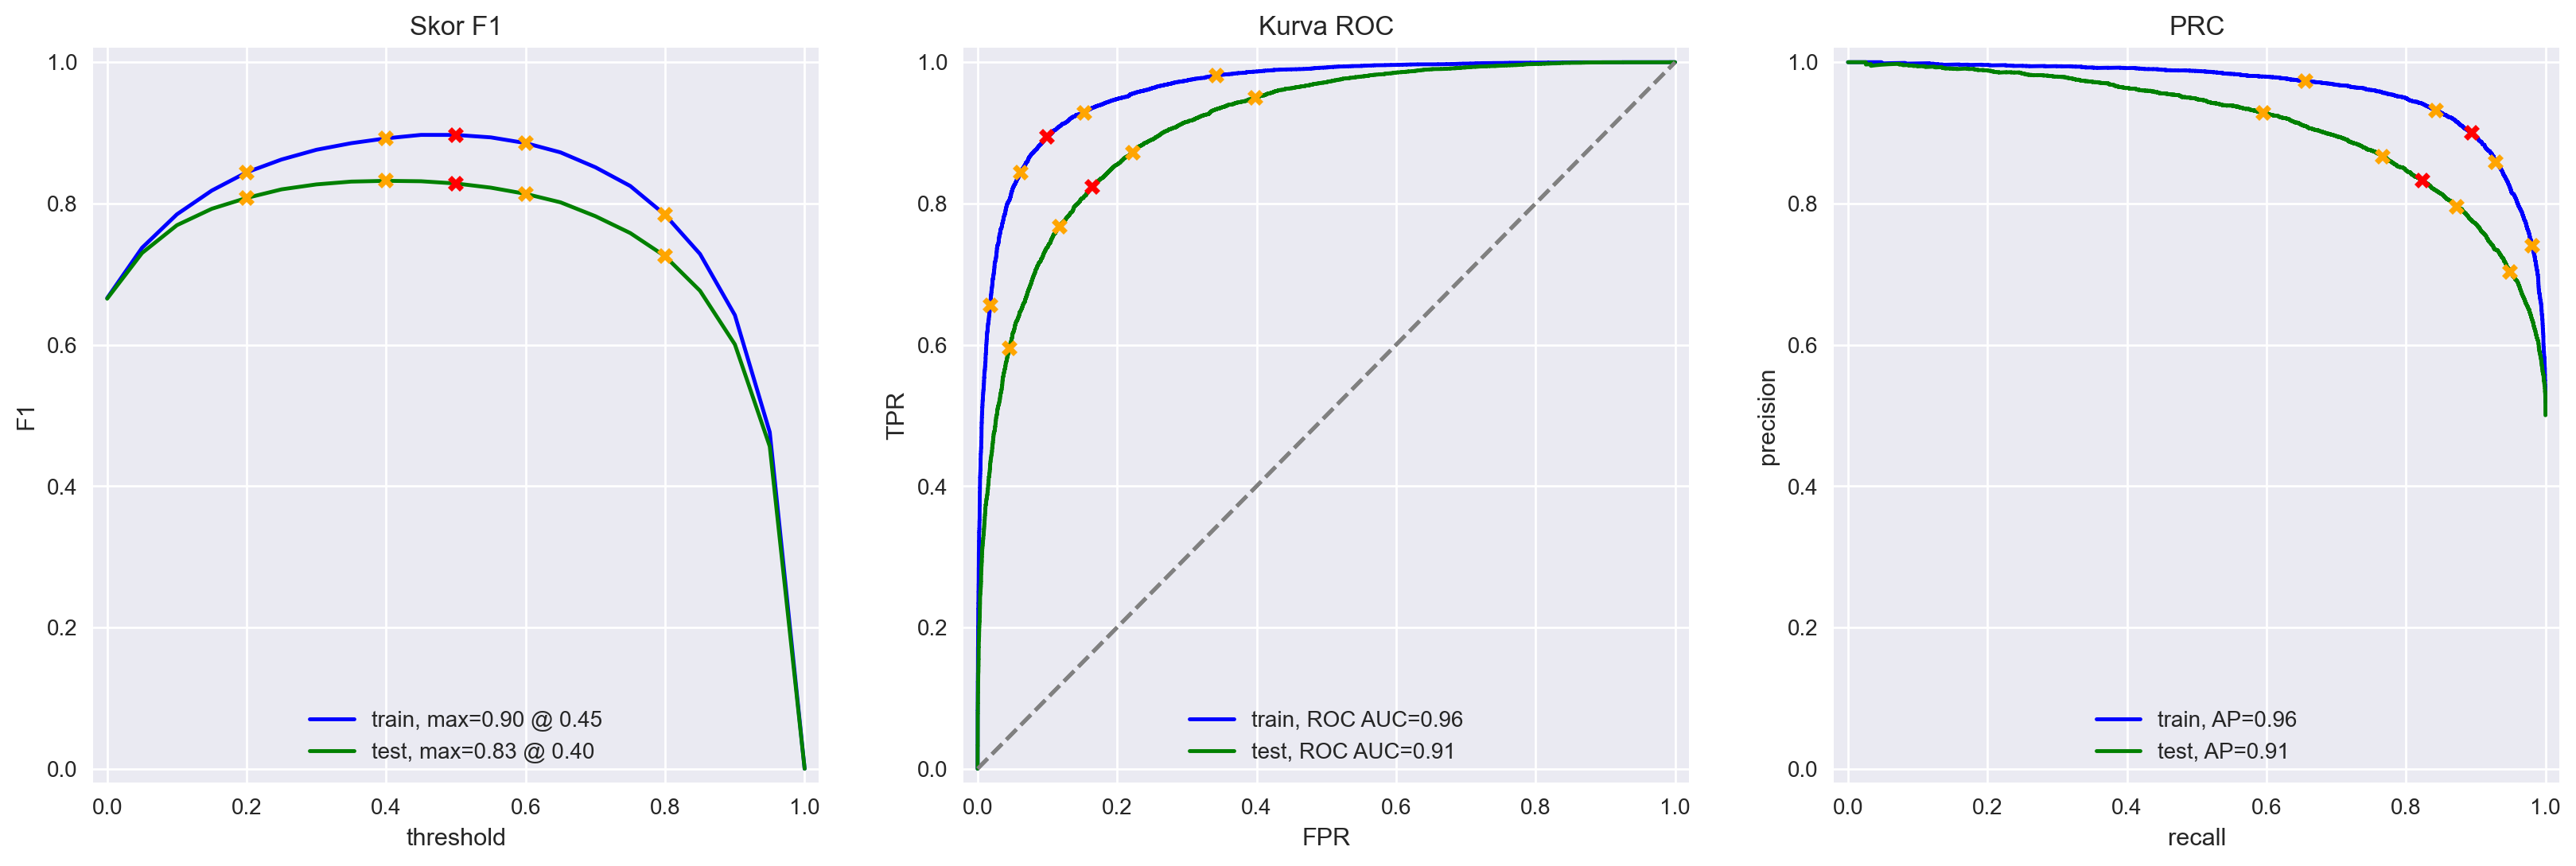

In [55]:
evaluate_model(cbo_test, train_features_3, train_target, test_features_3, test_target)

**Findings :**
- F1 score that generated by CatBoost with Bert gives is not better from previous models, so does the overfitting

## Review

In [56]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model Anda sendiri terhadap ulasan Anda, ini hanyalah sekadar contoh 

my_reviews = pd.DataFrame([
    'All in all I found it an intense, taxing but highly rewarding watch. This is film making at it finest.', 
    "I wish I loved this movie more than I did. Don't get me wrong, it's a solid action movie with jaw-dropping stunts", 
    'A top-rank film in its genre. Amazing action sequences and first-rate production values.',     
    'This movie was the best movie I have ever seen. The visual effects were more than just Oscar worthy.', 
    'The rumors about it feeling disjointed and a sudden shift/disconnected ending were completely true.', 
    "Bare minimum for a movie is to have a character start somewhere and end somewhere else. Unfortunately this didn't have that.", 
    "There are other issues I have with this film, such as the CGI. While it wasn't poor, I hated the style.", 
    'It was nothing new, it was very predictable. The movie was very slow and boring.' 
], columns=['review'])

### Model 0

In [57]:
# Regular Expression - Constant

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

my_reviews

C:\Users\Mahendra Alfath\AppData\Local\Temp\ipykernel_19152\3201104685.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')


,review,review_norm
0,"All in all I found it an intense, taxing but h...",all in all i found it an intense taxing but h...
1,I wish I loved this movie more than I did. Don...,i wish i loved this movie more than i did don...
2,A top-rank film in its genre. Amazing action s...,a top rank film in its genre amazing action s...
3,This movie was the best movie I have ever seen...,this movie was the best movie i have ever seen...
4,The rumors about it feeling disjointed and a s...,the rumors about it feeling disjointed and a s...
5,Bare minimum for a movie is to have a characte...,bare minimum for a movie is to have a characte...
6,"There are other issues I have with this film, ...",there are other issues i have with this film ...
7,"It was nothing new, it was very predictable. T...",it was nothing new it was very predictable t...


### Model 1.1

In [58]:
# NLTK, TF-IDF, LR

texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_1.predict_proba(tfidf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.88:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.87:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
0.93:  a top rank film in its genre  amazing action sequences and first rate production values 
0.85:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.40:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.09:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.06:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.00:  it was nothing new  it was very predictable  the movie was very slow and boring 


### Model 1.2

In [60]:
# NLTK, TF-IDF, XGBoost

texts = my_reviews['review_norm']

my_reviews_pred_prob = xgbo_test.predict_proba(tfidf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.81:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.74:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
0.81:  a top rank film in its genre  amazing action sequences and first rate production values 
0.86:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.68:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.43:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.36:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.16:  it was nothing new  it was very predictable  the movie was very slow and boring 


### Model 2.1

In [61]:
# Spacy, TF-IDF, LR

texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_2.predict_proba(tfidf_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.94:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.76:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
0.94:  a top rank film in its genre  amazing action sequences and first rate production values 
0.68:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.48:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.04:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.11:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.04:  it was nothing new  it was very predictable  the movie was very slow and boring 


### Model 2.2

In [62]:
# Spacy, TF-IDF, LightGBM

texts = my_reviews['review_norm']

my_reviews_pred_prob = lgb_test.predict_proba(tfidf_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.70:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.76:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
0.76:  a top rank film in its genre  amazing action sequences and first rate production values 
0.70:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.65:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.52:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.47:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.33:  it was nothing new  it was very predictable  the movie was very slow and boring 


### Model 3.1

In [63]:
# Bert, LR

texts = my_reviews['review_norm']

my_reviews_features = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = lr_3.predict_proba(my_reviews_features)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.98:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.97:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
1.00:  a top rank film in its genre  amazing action sequences and first rate production values 
1.00:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.95:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.06:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.13:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.00:  it was nothing new  it was very predictable  the movie was very slow and boring 


### Model 3.2

In [64]:
# Bert, CatBoost

texts = my_reviews['review_norm']

my_reviews_features = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = cbo_test.predict_proba(my_reviews_features)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.84:  all in all i found it an intense  taxing but highly rewarding watch  this is film making at it fines
0.92:  i wish i loved this movie more than i did  don t get me wrong  it s a solid action movie with jaw dr
0.99:  a top rank film in its genre  amazing action sequences and first rate production values 
0.97:  this movie was the best movie i have ever seen  the visual effects were more than just oscar worthy 
0.86:  the rumors about it feeling disjointed and a sudden shift disconnected ending were completely true 
0.23:  bare minimum for a movie is to have a character start somewhere and end somewhere else  unfortunatel
0.16:  there are other issues i have with this film  such as the cgi  while it wasn t poor  i hated the sty
0.03:  it was nothing new  it was very predictable  the movie was very slow and boring 


## Summary

1. **Data Description**
- Dataset contain 17 columns with 47.331 rows
- The film start in 1894 and 2010 at the end of the period, while average rating start from 1.4 to 9.7
- Slight difference in both original and primary title
- Only 2 missing values for each columns in average rating and votes, we can drop it later

2. **EDA**
- Film and Rating distribution for years
    - Total of movies are incredibly increasing with fluctuation from 1864 to 2010
    - At the beginning of the period, the reviews decrease and continue rising to 1960. For about 8 years the reviews decrease and graduallly increase at the end of the period
- Rating per movies with calculation
    - The higher the number of reviews, the lower the number of films, except for 30 reviews happen in just over 400 movies
- Rating distribution
    - Rating 1 and 10 are the highest number among all, 5 and 6 ratings are the lowest even reached nothing, while the others are almost the same ranging between 2000 to just under 3000
- Positive and Negative Reviews
    - Even though the different between positive and negative reviews have small number, but on the distribution seem huge different

3. **Evaluation Procedure**
- Dataset was already divided into one section for training/testing
- Balance amount of train and test data

4. **Model Training and Testing**
- Model 0 (Constant)
    - F1 score is far from the specified threshold value in dummy classifier model
- Model 1.1 (NLTK, TF-IDF, LR)
    - LR with NLTK, TF-IDF generates better F1 score than dummy classifier model and passes the threshold value.
- Model 1.2 (NLTK, TF-IDF, XGBoost)
    - F1 score of XGB with NLTK, TF-IDF is not better than vectorization results with Logistic Regression, but this model is less prone to overfitting that makes this model better.
- Model 2.1 (Spacy, TF-IDF, LR)
    - LR with spacy generates f1 score slightly better than with NLTK vectorization.
- Model 2.2 (Spacy, TF-IDF, LGB)
    - LGBM with Spacy, TF-IDF generates F1 score that is not better than LR model with Spacy, TF-IDF.
- Model 3.1 (Bert, LR)
    - F1 score that generated by LR model with Bert gives is not significantly different from previous models, but this has better performance from overfitting.
- Model 3.2 (Bert, CatBoost)
    - F1 score that generated by CatBoost with Bert gives is not better from previous models, so does the overfitting

## General Conclusion

- **Linear Regression** with all vectorization model (NLTK, Spacy, Bert) genarates the best result for F1 score, this model also has good result in terms of overfitting that the others
- The **BERT** model has the best result for overfitting, but the **Spacy** has the best result on F1 Score